In [ ]:
# Environment Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from captum.attr import IntegratedGradients, Occlusion
import warnings
import re
from glob import glob
from tensorflow.keras.utils import to_categorical
import random
import numpy as np
import torch

warnings.filterwarnings('ignore')

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [2]:
# Load preprocessed data
# This assumes you have already run the feature extraction pipeline
# and saved the results in myData.npz
import os
if os.path.isfile("myData.npz"):
    print("✅ Loading preprocessed features...")
    with np.load("myData.npz") as data:
        myData = data['myData']       # Mel spectrograms (N, 128, 256, 1)
        myData2 = data['myData2']     # Topological features (N, 64, 64, 6)
        myY = data['myY']             # One-hot labels (N, 6)
        myActors = data['myActors']   # Actor IDs
        myDatasets = data['myDatasets']  # Dataset names

    print(f"Mel spectrograms shape: {myData.shape}")
    print(f"Topological features shape: {myData2.shape}")
    print(f"Labels shape: {myY.shape}")
    print(f"Number of unique actors: {len(np.unique(myActors))}")
    print(f"Number of unique datasets: {len(np.unique(myDatasets))}")
else:
    folder = './savefiles2'

    def findFilesFromPattern(pattern):
        pattern = re.compile(pattern + r'_(.*?)_(.*?)_(.*?)_(\d+)_(\d+)\.npy')
        heatmaps_dict = {}

        for filename in os.listdir(folder):
            match = pattern.match(filename)
            if match:
                dataset, actor, emotion, i, j = map(str, match.groups())
                i, j = int(i), int(j)
                filepath = os.path.join(folder, filename)
                data = np.load(filepath)

                heatmaps_dict[f'{dataset}_{actor}_{emotion}_{j // 2}_{j%2}'] = {'data': data, 'dataset': dataset, 'actor': actor, 'emotion':emotion, 'type': j}

        return heatmaps_dict

    mfccwasserstein = findFilesFromPattern('wassersteinMfccHeat')
    melwasserstein = findFilesFromPattern('wassersteinHeat')
    meltimeeuclid = findFilesFromPattern('timeMetricHeat')
    meleuclid = findFilesFromPattern('euclideanHeat')

    def load_spectrograms(prefixes, path='./savefiles'):
        patterns = []
        for prefix in prefixes:
            patterns.append(os.path.join(path, f"{prefix}_*.npy"))
        my_globs = glob(patterns[0])
        for pattern in patterns[1:]:
            my_globs = my_globs + glob(pattern)
        file_list = sorted(my_globs)
        return [np.load(file) for i, file in enumerate(file_list)]

    myRaw = load_spectrograms(["savee", 'tess', 'radvess', 'cremad'])
    print(len(mfccwasserstein))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1]))
    print(np.array([[meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] == 0]]).shape)

    print(len(myRaw))

    myData = np.array([myRaw])
    print('finish data')
    myData = myData.astype('float32')
    myData = np.transpose(myData, (1, 2, 3, 0))
    myEmotionMap = {
        'neutral': 1, 'happy':2, 'sad':3, 'angry':4, 'fearful':5, 'disgust':6, 'calm':7, 'surprised':8
    }
    myY = np.array(
        [myEmotionMap[mfccwasserstein[key]['emotion']] -1 for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myActors = np.array(
        [mfccwasserstein[key]['actor'] + '_' + mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myDatasets = np.array(
        [mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    print(np.unique(myActors))

    print(np.unique(myY))

    myY = to_categorical(myY, num_classes=6)

    myData2 = np.array([
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0],
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 1],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 0],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 1],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 1]
                        ])
    print('finish data')
    myData2 = myData2.astype('float32')
    print(myData2.shape)
    myData2 = np.transpose(myData2, (1, 2, 3, 0))
    print(myData2.shape)
    np.savez_compressed(
        "myData.npz",
        myData=myData,
        myData2=myData2,
        myY=myY,
        myActors=myActors,
        myDatasets=myDatasets,
    )

✅ Loading preprocessed features...
Mel spectrograms shape: (11318, 128, 256, 1)
Topological features shape: (11318, 32, 32, 6)
Labels shape: (11318, 6)
Number of unique actors: 121
Number of unique datasets: 4


Generating topological feature visualizations...


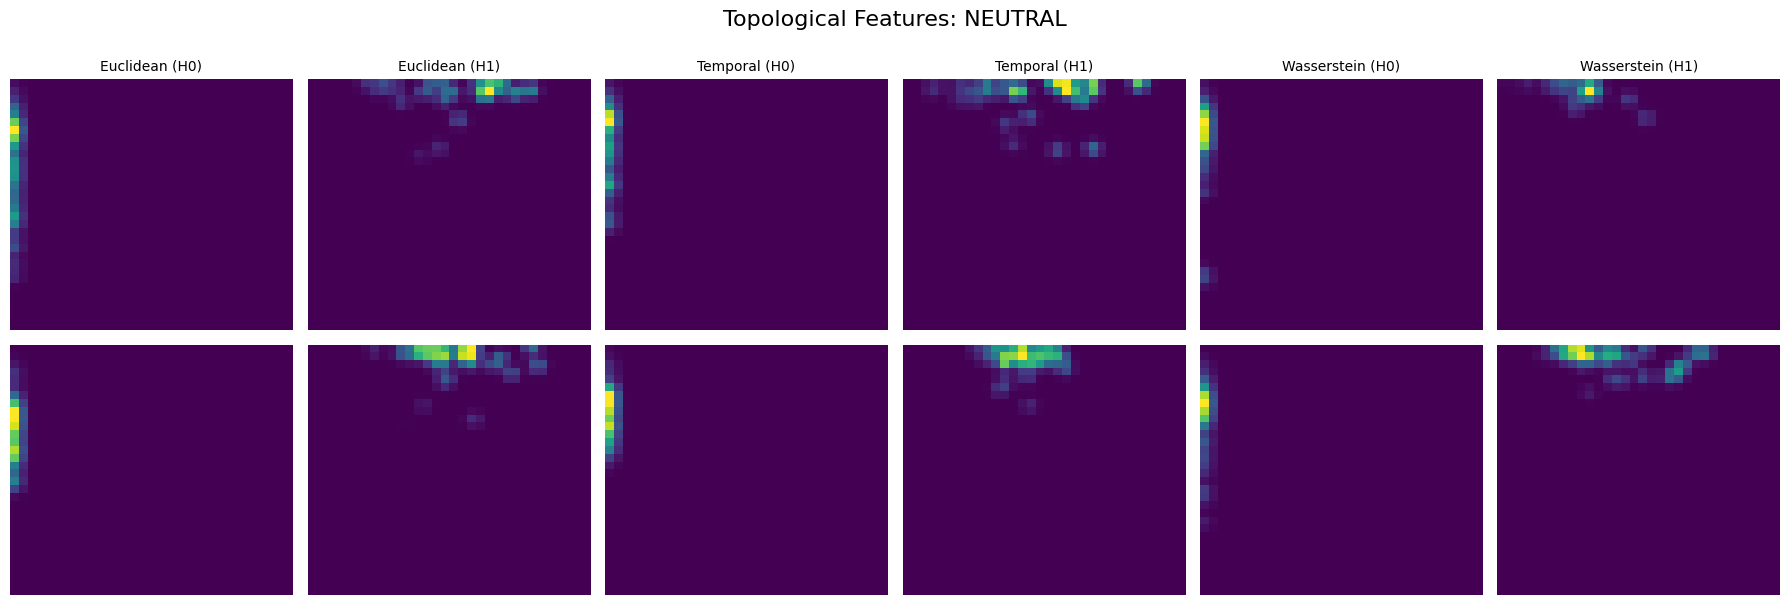

Saved: topology_neutral.png



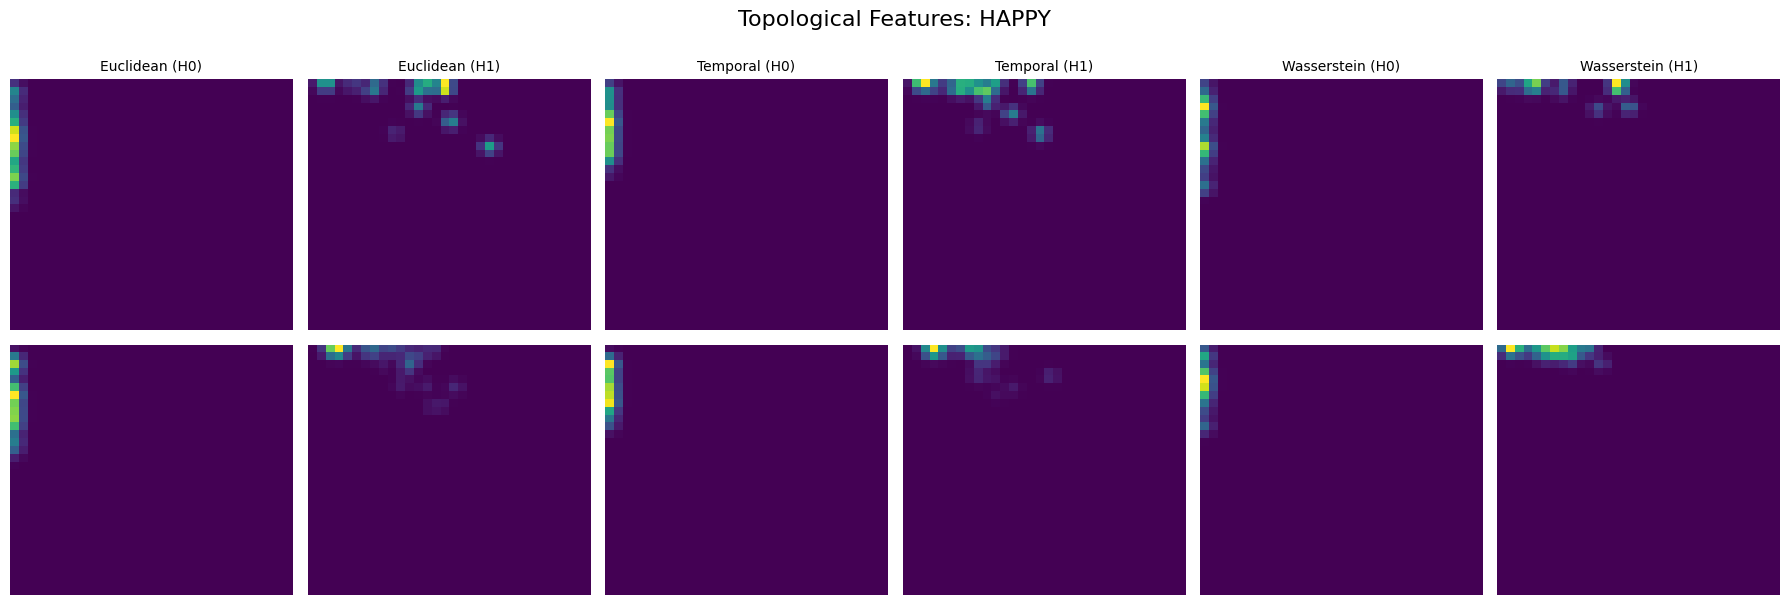

Saved: topology_happy.png



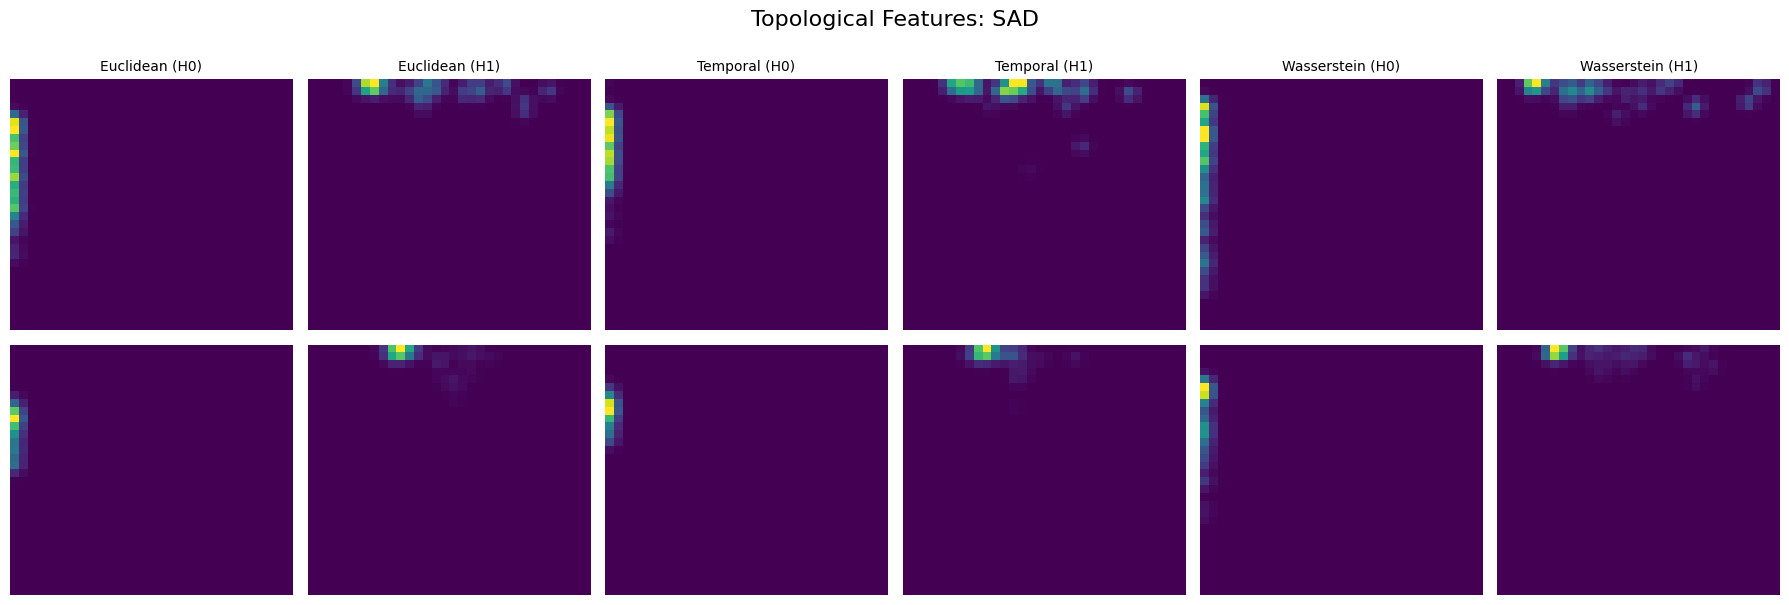

Saved: topology_sad.png



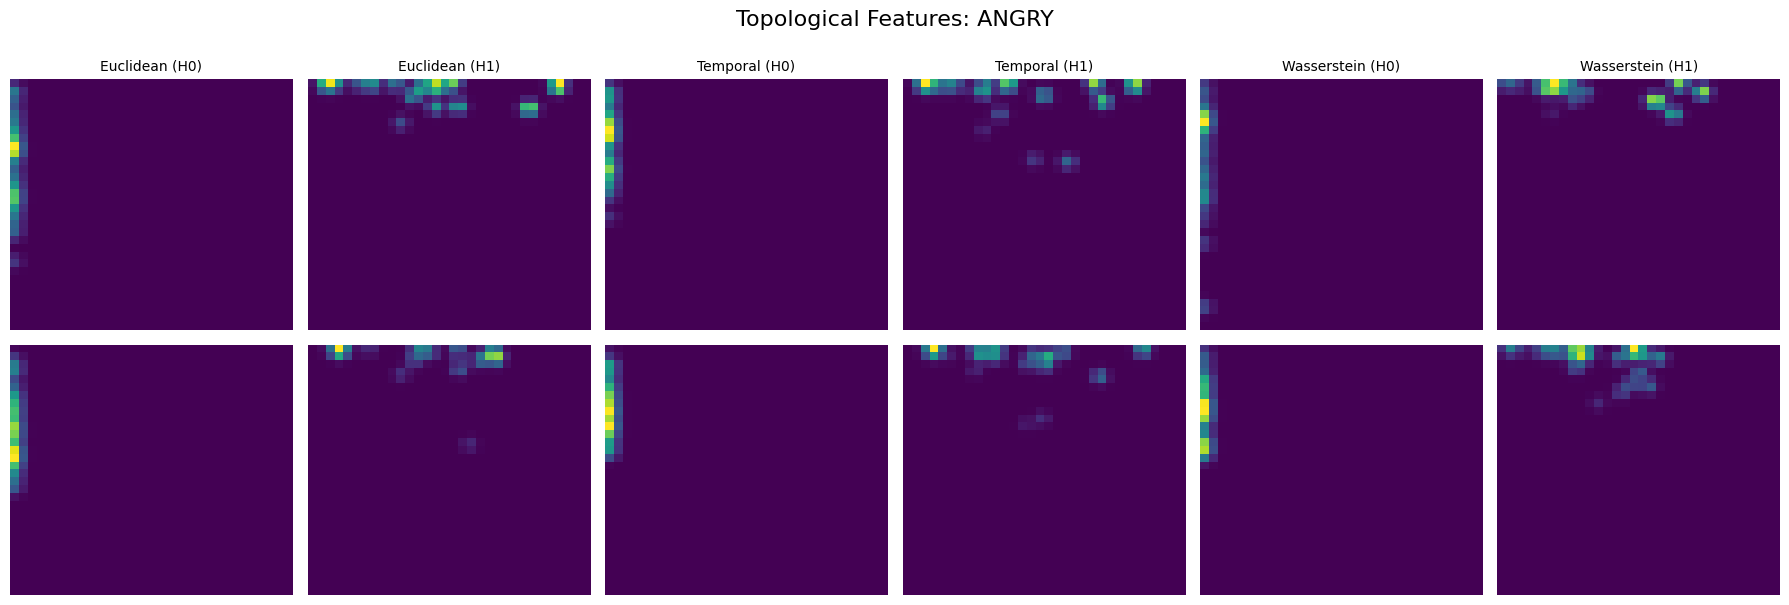

Saved: topology_angry.png



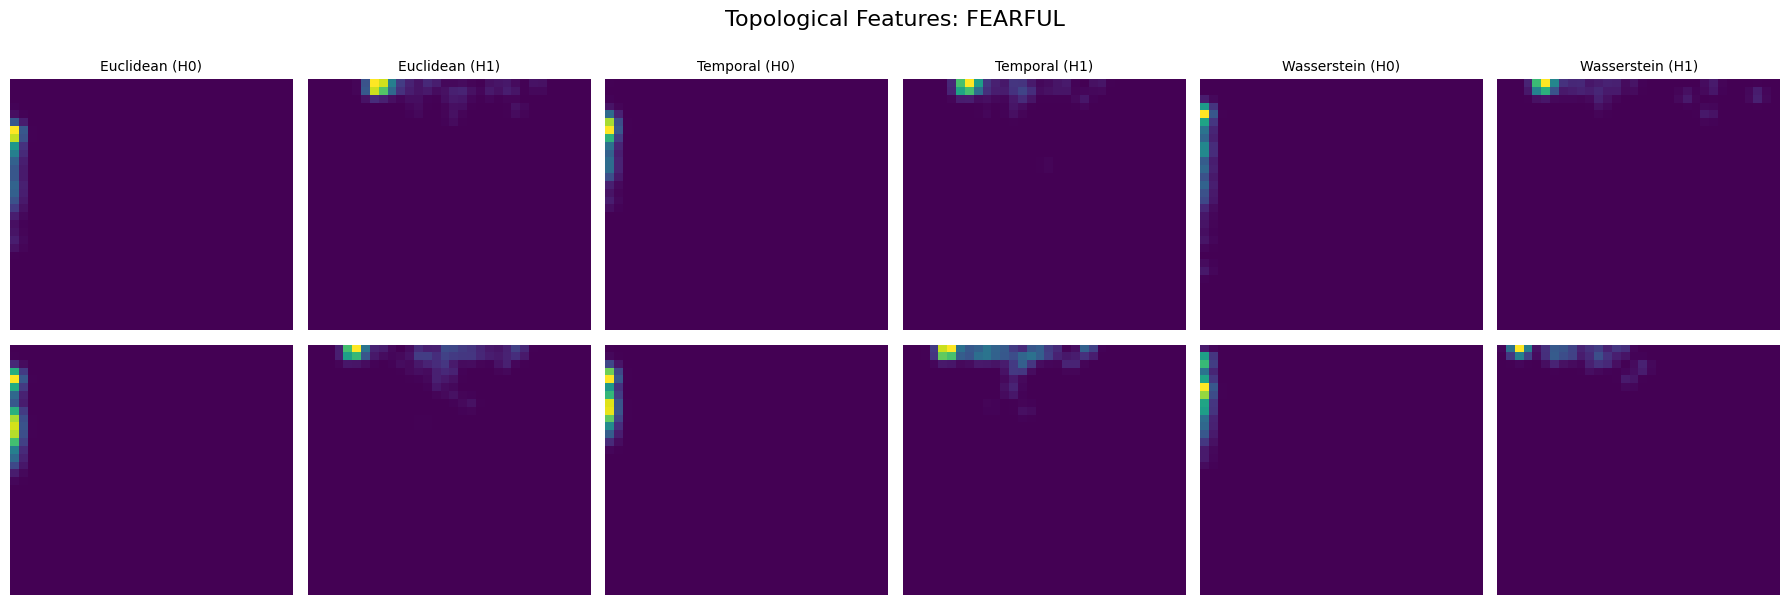

Saved: topology_fearful.png



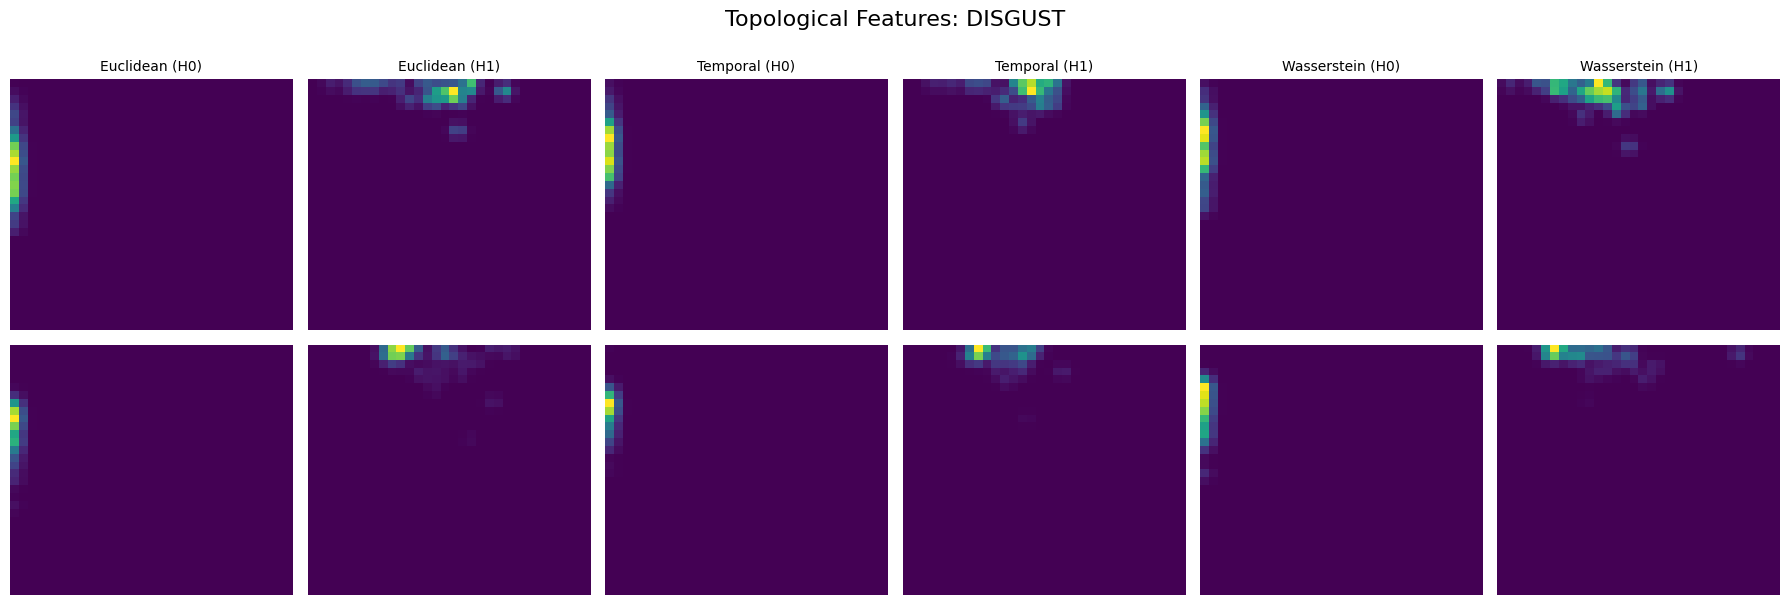

Saved: topology_disgust.png



In [3]:
# Visualize example topological features for each emotion
def visualize_topological_channels(data, labels, actors, num_samples=3):
    """
    Visualize topological channels for each emotion class.
    """
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    channel_names = [
        'Euclidean (H0)',
        'Euclidean (H1)',
        'Temporal (H0)',
        'Temporal (H1)',
        'Wasserstein (H0)',
        'Wasserstein (H1)'
    ]

    label_ids = np.argmax(labels, axis=1)

    for emotion_id in range(6):
        emotion_mask = label_ids == emotion_id
        emotion_samples = data[emotion_mask]

        # Select random samples
        indices = np.random.choice(len(emotion_samples), min(num_samples, len(emotion_samples)), replace=False)

        fig, axes = plt.subplots(num_samples, 6, figsize=(18, 3*num_samples))
        fig.suptitle(f'Topological Features: {emotions[emotion_id].upper()}', fontsize=16, y=1.00)

        for row, idx in enumerate(indices):
            sample = emotion_samples[idx]  # Shape: (H, W, 6)
            for col in range(6):
                ax = axes[row, col] if num_samples > 1 else axes[col]
                ax.imshow(sample[:, :, col], cmap='viridis', aspect='auto')
                if row == 0:
                    ax.set_title(channel_names[col], fontsize=10)
                ax.axis('off')

        plt.tight_layout()
        plt.savefig(f'topology_{emotions[emotion_id]}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: topology_{emotions[emotion_id]}.png\n")

# Visualize topological features
if 'myData2' in locals():
    print("Generating topological feature visualizations...")
    visualize_topological_channels(myData2, myY, myActors, num_samples=2)

In [4]:
# Model 1: Mel Spectrogram CNN
class MelSpectrogramCNN(nn.Module):
    """Baseline CNN for mel spectrograms."""
    def __init__(self, num_classes=6):
        super(MelSpectrogramCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Model 2: Topological Feature CNN with Embedding Output
class TopologicalCNN(nn.Module):
    """CNN for 6-channel topological features with optional embedding return."""
    def __init__(self, num_classes=6):
        super(TopologicalCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, return_embedding=False):
        f = self.features(x)
        z = self.classifier[:-1](f)  # 64-dim embedding
        logits = self.classifier[-1](z)
        return z if return_embedding else logits


# Model 3: Combined Fusion Model
class CombinedFusionModel(nn.Module):
    """Late fusion of mel spectrogram and topological features."""
    def __init__(self, num_classes=6):
        super(CombinedFusionModel, self).__init__()
        # Mel branch
        self.mel_branch = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Topological branch
        self.topo_branch = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, mel_input, topo_input):
        mel_emb = self.mel_branch(mel_input)
        topo_emb = self.topo_branch(topo_input)
        combined = torch.cat([mel_emb, topo_emb], dim=1)
        return self.classifier(combined)

print("✅ Model architectures defined")

✅ Model architectures defined


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_group_split_3way(
    y,
    groups,
    myDatasets,
    val_size=0.2,
    test_size=0.2,
    random_state=42,
):
    y = np.asarray(y)
    groups = np.asarray(groups)
    myDatasets = np.asarray(myDatasets)
    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({"y": y, "group": groups, "dataset": myDatasets})

    group_df = (
        df.groupby("group")
          .agg(
              y_group=("y", lambda s: s.value_counts().index[0]),
              dataset_group=("dataset", lambda s: s.value_counts().index[0]),
          )
          .reset_index()
    )

    datasets = group_df["dataset_group"].unique()
    n_groups = len(group_df)

    ds_counts = group_df["dataset_group"].value_counts()
    bad = ds_counts[ds_counts < 2].index.to_list()
    if bad:
        raise ValueError(f"Cannot guarantee dataset coverage in both train and test; datasets with <2 groups: {bad}")

    # Target group counts
    n_test = max(int(np.round(test_size * n_groups)), len(datasets))
    n_val = int(np.round(val_size * n_groups))

    if n_test + n_val >= n_groups:
        raise ValueError("Not enough groups to allocate train/val/test with these sizes.")

    # After taking test+val, train must still have at least one per dataset
    if (n_groups - n_test - n_val) < len(datasets):
        raise ValueError(
            "Not enough remaining groups to guarantee at least one group per dataset in TRAIN. "
            "Reduce val_size and/or test_size."
        )

    # -------------------------
    # Force disjoint coverage groups for TEST and TRAIN
    # -------------------------
    forced_test = []
    forced_train = []

    for ds in datasets:
        ds_groups = group_df[group_df["dataset_group"] == ds].copy()

        # choose one group for test (biased by label distribution inside dataset)
        y_counts = ds_groups["y_group"].value_counts()
        labels = y_counts.index.to_numpy()
        probs = (y_counts / y_counts.sum()).to_numpy()
        chosen_label = rng.choice(labels, p=probs)

        candidates = ds_groups.loc[ds_groups["y_group"] == chosen_label, "group"].to_numpy()
        g_test = rng.choice(candidates)
        forced_test.append(g_test)

        # choose a different group for train
        remaining = ds_groups.loc[ds_groups["group"] != g_test, "group"].to_numpy()
        g_train = rng.choice(remaining)
        forced_train.append(g_train)

    forced_test = np.array(pd.unique(forced_test))
    forced_train = np.array(pd.unique(forced_train))

    # Ensure forced_train does not overlap forced_test (defensive fix)
    overlap = set(forced_train).intersection(set(forced_test))
    if overlap:
        for g in list(overlap):
            ds = group_df.loc[group_df["group"] == g, "dataset_group"].iloc[0]
            ds_groups = group_df[group_df["dataset_group"] == ds]["group"].to_numpy()
            used = set(forced_test).union(set(forced_train))
            repl = next((x for x in ds_groups if x not in used), None)
            if repl is None:
                repl = next(x for x in ds_groups if x not in set(forced_test))
            forced_train[forced_train == g] = repl

    forced_test_set = set(forced_test.tolist())
    forced_train_set = set(forced_train.tolist())

    # -------------------------
    # Fill remaining TEST slots (IMPORTANT: never sample forced_train into test)
    # -------------------------
    remaining_test_slots = n_test - len(forced_test_set)
    eligible_for_test = group_df[
        (~group_df["group"].isin(forced_test_set)) &
        (~group_df["group"].isin(forced_train_set))
    ].reset_index(drop=True)

    extra_test = np.array([], dtype=group_df["group"].dtype)
    if remaining_test_slots > 0:
        rem_n = len(eligible_for_test)
        if remaining_test_slots > rem_n:
            # If this happens, expand eligibility by allowing forced_train (but then train coverage may break).
            # Better to fail loudly.
            raise ValueError(
                "Not enough eligible groups to fill test without stealing reserved train-coverage groups. "
                "Reduce test_size."
            )

        if remaining_test_slots == rem_n:
            extra_test = eligible_for_test["group"].to_numpy()
        else:
            sss = StratifiedShuffleSplit(
                n_splits=1,
                test_size=remaining_test_slots / rem_n,
                random_state=random_state,
            )
            idx = np.arange(rem_n)
            _, extra_idx = next(sss.split(idx, eligible_for_test["y_group"]))
            extra_test = eligible_for_test.loc[extra_idx, "group"].to_numpy()

    test_groups = np.array(list(forced_test_set.union(set(extra_test.tolist()))))
    test_set = set(test_groups.tolist())

    # -------------------------
    # Build remaining pool for TRAIN/VAL
    #   - Keep forced_train always in TRAIN (never in VAL)
    # -------------------------
    remaining_after_test = group_df[~group_df["group"].isin(test_set)].reset_index(drop=True)

    split_pool = remaining_after_test[~remaining_after_test["group"].isin(forced_train_set)].reset_index(drop=True)

    n_val = min(n_val, len(split_pool))
    if n_val <= 0:
        val_set = set()
        train_set = set(remaining_after_test["group"].to_list())  # includes forced_train
    else:
        sss_inner = StratifiedShuffleSplit(
            n_splits=1,
            test_size=n_val / len(split_pool),
            random_state=random_state + 1,
        )
        idx = np.arange(len(split_pool))
        train_idx_g, val_idx_g = next(sss_inner.split(idx, split_pool["y_group"]))

        val_set = set(split_pool.loc[val_idx_g, "group"].to_list())
        train_set = set(remaining_after_test["group"].to_list()) - val_set  # ensures disjoint, includes forced_train

    # -------------------------
    # Sanity checks
    # -------------------------
    if train_set & test_set:
        raise RuntimeError("Train/Test overlap detected (groups).")
    if val_set & test_set:
        raise RuntimeError("Val/Test overlap detected (groups).")
    if train_set & val_set:
        raise RuntimeError("Train/Val overlap detected (groups).")

    expected_ds = set(group_df["dataset_group"].unique())
    got_test = set(group_df.loc[group_df["group"].isin(list(test_set)), "dataset_group"].unique())
    got_train = set(group_df.loc[group_df["group"].isin(list(train_set)), "dataset_group"].unique())

    if expected_ds - got_test:
        raise RuntimeError(f"Dataset coverage constraint failed in TEST: missing {expected_ds - got_test}")
    if expected_ds - got_train:
        raise RuntimeError(f"Dataset coverage constraint failed in TRAIN: missing {expected_ds - got_train}")

    # -------------------------
    # Map groups -> sample indices
    # -------------------------
    train_idx = np.where(df["group"].isin(list(train_set)))[0]
    val_idx = np.where(df["group"].isin(list(val_set)))[0]
    test_idx = np.where(df["group"].isin(list(test_set)))[0]

    return train_idx, val_idx, test_idx




# Perform split
if 'myY' in locals():
    groups = myActors
    train_idx, val_idx, test_idx = stratified_group_split_3way(
        y=np.argmax(myY, axis=1),
        myDatasets=myDatasets,
        groups=groups,
        val_size=0.2,
        test_size=0.2
    )

    print(f"Train speakers: {len(np.unique(myActors[train_idx]))}")
    print(f"Train datasets: {len(np.unique(myDatasets[train_idx]))}")
    print(f"Val speakers: {len(np.unique(myActors[val_idx]))}")
    print(f"Test speakers: {len(np.unique(myActors[test_idx]))}")
    print(f"Test datasets: {len(np.unique(myDatasets[test_idx]))}")

    print(f"\nTrain samples: {len(train_idx)}")
    print(f"Val samples: {len(val_idx)}")
    print(f"Test samples: {len(test_idx)}")

    # Filter for non-noisy test samples (clean evaluation)
    X_train, X_val, X_test = myData[train_idx], myData[val_idx], myData[test_idx]
    X_train2, X_val2, X_test2 = myData2[train_idx], myData2[val_idx], myData2[test_idx]
    y_train, y_val, y_test = myY[train_idx], myY[val_idx], myY[test_idx]

    # Convert to PyTorch tensors
    # Filter by noise for training (include both clean and noisy)
    X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_train2_tensor = torch.tensor(X_train2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

    X_val_tensor = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_val2_tensor = torch.tensor(X_val2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_val_tensor = torch.tensor(np.argmax(y_val, axis=1), dtype=torch.long)

    # Test: only clean samples
    X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_test2_tensor = torch.tensor(X_test2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

    print(f"\nTensor shapes:")
    print(f"Train mel: {X_train_tensor.shape}")
    print(f"Train topo: {X_train2_tensor.shape}")
    print(f"Test mel: {X_test_tensor.shape}")
    print(f"Test topo: {X_test2_tensor.shape}")

Train speakers: 73
Train datasets: 4
Val speakers: 24
Test speakers: 24
Test datasets: 4

Train samples: 6605
Val samples: 1877
Test samples: 2836

Tensor shapes:
Train mel: torch.Size([6605, 1, 128, 256])
Train topo: torch.Size([6605, 6, 32, 32])
Test mel: torch.Size([2836, 1, 128, 256])
Test topo: torch.Size([2836, 6, 32, 32])


In [6]:
for i in (np.unique(myActors[train_idx])):
    print(i)

01_radvess
04_radvess
05_radvess
06_radvess
08_radvess
09_radvess
1001_cremad
1002_cremad
1003_cremad
1004_cremad
1005_cremad
1007_cremad
1009_cremad
1010_cremad
1011_cremad
1017_cremad
1018_cremad
1019_cremad
1021_cremad
1023_cremad
1024_cremad
1025_cremad
1026_cremad
1027_cremad
1028_cremad
1029_cremad
1031_cremad
1033_cremad
1037_cremad
1038_cremad
1039_cremad
1040_cremad
1041_cremad
1042_cremad
1043_cremad
1046_cremad
1047_cremad
1048_cremad
1050_cremad
1055_cremad
1056_cremad
1057_cremad
1058_cremad
1059_cremad
1060_cremad
1064_cremad
1066_cremad
1067_cremad
1069_cremad
1073_cremad
1074_cremad
1075_cremad
1077_cremad
1078_cremad
1079_cremad
1082_cremad
1083_cremad
1085_cremad
1088_cremad
1089_cremad
1090_cremad
1091_cremad
11_radvess
14_radvess
17_radvess
18_radvess
19_radvess
21_radvess
22_radvess
23_radvess
JE_savee
KL_savee
OAF_tess


In [7]:
for i in (np.unique(myActors[test_idx])):
    print(i)

02_radvess
03_radvess
1006_cremad
1008_cremad
1013_cremad
1014_cremad
1016_cremad
1022_cremad
1044_cremad
1045_cremad
1053_cremad
1065_cremad
1068_cremad
1076_cremad
1080_cremad
1081_cremad
1086_cremad
10_radvess
13_radvess
15_radvess
16_radvess
20_radvess
JK_savee
YAF_tess


In [8]:
for i in (np.unique(myActors[val_idx])):
    print(i)

07_radvess
1012_cremad
1015_cremad
1020_cremad
1030_cremad
1032_cremad
1034_cremad
1035_cremad
1036_cremad
1049_cremad
1051_cremad
1052_cremad
1054_cremad
1061_cremad
1062_cremad
1063_cremad
1070_cremad
1071_cremad
1072_cremad
1084_cremad
1087_cremad
12_radvess
24_radvess
DC_savee


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3,
                model_name="model", device=device):
    """
    Generic training function with validation.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
    top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            if len(batch) == 3:  # Combined model
                X_batch, X2_batch, y_batch = batch
                X_batch, X2_batch, y_batch = X_batch.to(device), X2_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch, X2_batch)
            else:  # Single input model
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    X_val, X2_val, y_val = batch
                    X_val, X2_val, y_val = X_val.to(device), X2_val.to(device), y_val.to(device)
                    outputs = model(X_val, X2_val)
                else:
                    X_val, y_val = batch
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    outputs = model(X_val)

                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                preds = torch.softmax(outputs, dim=1)
                val_preds.append(preds)
                val_labels.append(y_val)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_auc = auroc(val_preds, val_labels).item()
        val_top3 = top3acc(val_preds, val_labels).item()
        y_pred = torch.argmax(val_preds, dim=1)
        accuracy = (y_pred == val_labels).float().mean().item()

        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_auc'].append(val_auc)
        history['val_acc'].append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"train_loss: {train_loss/len(train_loader):.4f} - "
              f"val_loss: {val_loss/len(val_loader):.4f} - "
              f"val_auc: {val_auc:.4f} - "
              f"val_top3: {val_top3:.4f} - "
              f"val_acc: {accuracy:.4f}")

        # Save best model
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print(f"✅ Saved best model: {accuracy:.4f}")

    return model, history


from collections import defaultdict

def evaluate_model(model, test_loader, model_path, device=device):
    """
    Evaluate model on test set and compute accuracy per dataset.
    """
    model.load_state_dict(torch.load(model_path))
    model.eval()

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
    top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

    all_preds, all_labels, all_probs = [], [], []

    # Per-dataset tracking
    dataset_correct = defaultdict(int)
    dataset_total = defaultdict(int)

    with torch.no_grad():
        for batch in test_loader:

            if len(batch) == 4:
                # Two-input model
                X_batch, X2_batch, y_batch, dataset_batch = batch
                X_batch = X_batch.to(device)
                X2_batch = X2_batch.to(device)
                outputs = model(X_batch, X2_batch)

            elif len(batch) == 3:
                # Single-input model
                X_batch, y_batch, dataset_batch = batch
                X_batch = X_batch.to(device)
                outputs = model(X_batch)

            else:
                raise ValueError("Unexpected batch format")

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Store global results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())
            all_probs.append(probs)

            # Per-dataset accuracy
            for pred, label, ds in zip(preds.cpu(), y_batch, dataset_batch):
                dataset_total[ds] += 1
                if pred == label:
                    dataset_correct[ds] += 1

    all_probs = torch.cat(all_probs)
    all_labels_tensor = torch.tensor(all_labels).to(device)

    test_auc = auroc(all_probs, all_labels_tensor).item()
    test_top3 = top3acc(all_probs, all_labels_tensor).item()
    test_acc = (torch.argmax(all_probs, dim=1) == all_labels_tensor).float().mean().item()

    print(f"\nTest Results:")
    print(f"AUC: {test_auc:.4f}")
    print(f"Top-3 Accuracy: {test_top3:.4f}")
    print(f"Accuracy: {test_acc:.4f}")

    # Per-dataset accuracy
    print("\nAccuracy per dataset:")
    dataset_acc = {}
    for ds in dataset_total:
        acc = dataset_correct[ds] / dataset_total[ds]
        dataset_acc[ds] = acc
        print(f"{ds}: {acc:.4f}")

    # Classification report
    class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    report = classification_report(all_labels, all_preds, target_names=class_labels, output_dict=True)
    print("\nClassification Report:")
    print(report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return {
        'auc': test_auc,
        'top3_acc': test_top3,
        'acc': test_acc,
        'acc_per_dataset': dataset_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'report': report
    }

def get_macro_f1(res):
    # classification_report output dict typically has:
    # res["report"]["macro avg"]["f1-score"]
    return float(res["report"]["macro avg"]["f1-score"])

def summarize_with_f1(all_results):
    aucs  = np.array([r["auc"] for r in all_results], dtype=float)
    accs  = np.array([r["acc"] for r in all_results], dtype=float)
    top3s = np.array([r["top3_acc"] for r in all_results], dtype=float)
    f1s   = np.array([get_macro_f1(r) for r in all_results], dtype=float)

    return {
        "auc": (aucs.mean(),  aucs.std(ddof=1)),
        "acc": (accs.mean(),  accs.std(ddof=1)),
        "top3_acc": (top3s.mean(), top3s.std(ddof=1)),
        "macro_f1": (f1s.mean(),  f1s.std(ddof=1)),
    }

def summarize_acc_per_dataset(all_results):
    # assume each result has same dataset keys
    ds_keys = list(all_results[0]["acc_per_dataset"].keys())
    out = {}
    for ds in ds_keys:
        vals = np.array([r["acc_per_dataset"][ds] for r in all_results], dtype=float)
        out[ds] = (vals.mean(), vals.std(ddof=1))
    return out

from torch.utils.data import Dataset

class TensorDatasetWithNames(Dataset):
    def __init__(self, X, y, names):
        self.X = X
        self.y = y
        self.names = names

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.names[idx]


class TensorDatasetWithNamesComb(Dataset):
    def __init__(self, X, X2, y, names):
        self.X = X
        self.X2 = X2
        self.y = y
        self.names = names

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X2[idx], self.y[idx], self.names[idx]

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


print("✅ Training functions defined")

✅ Training functions defined


In [10]:
myDatasets[test_idx]

array(['cremad', 'cremad', 'cremad', ..., 'tess', 'tess', 'tess'],
      dtype='<U7')

In [11]:
y_test_tensor

tensor([3, 3, 3,  ..., 2, 2, 2])


==================== Seed 0 ====================
Epoch 1/40 - train_loss: 1.6805 - val_loss: 1.7598 - val_auc: 0.6814 - val_top3: 0.5320 - val_acc: 0.2557
✅ Saved best model: 0.2557
Epoch 2/40 - train_loss: 1.4106 - val_loss: 1.4331 - val_auc: 0.7916 - val_top3: 0.8372 - val_acc: 0.4108
✅ Saved best model: 0.4108
Epoch 3/40 - train_loss: 1.2130 - val_loss: 3.1739 - val_auc: 0.6504 - val_top3: 0.6051 - val_acc: 0.2025
Epoch 4/40 - train_loss: 1.1186 - val_loss: 1.9507 - val_auc: 0.7586 - val_top3: 0.6573 - val_acc: 0.2898
Epoch 5/40 - train_loss: 1.0470 - val_loss: 1.3612 - val_auc: 0.8204 - val_top3: 0.8380 - val_acc: 0.4608
✅ Saved best model: 0.4608
Epoch 6/40 - train_loss: 0.9814 - val_loss: 2.6632 - val_auc: 0.7210 - val_top3: 0.6842 - val_acc: 0.2525
Epoch 7/40 - train_loss: 0.9488 - val_loss: 1.6907 - val_auc: 0.8133 - val_top3: 0.7881 - val_acc: 0.4406
Epoch 8/40 - train_loss: 0.8946 - val_loss: 2.8613 - val_auc: 0.7306 - val_top3: 0.7153 - val_acc: 0.2957
Epoch 9/40 - train_lo

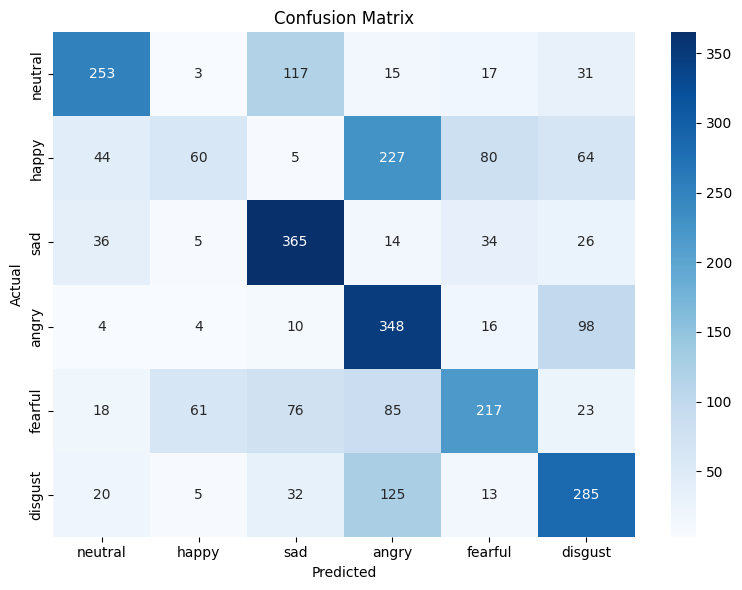

{'auc': 0.8614639639854431, 'top3_acc': 0.8962697982788086, 'acc': 0.5387870073318481, 'acc_per_dataset': {'cremad': 0.5584627964022895, 'radvess': 0.512987012987013, 'savee': 0.42857142857142855, 'tess': 0.535}, 'predictions': [4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 2, 5, 0, 5, 0, 0, 5, 5, 5, 5, 2, 5, 5, 5, 4, 4, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 1, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 3, 4, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 2, 0, 5, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 3, 5, 2, 5, 3, 3, 3, 3, 3, 5, 5, 4, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 4, 3, 5, 3, 5, 4, 5, 4, 4, 5, 2, 4, 4, 5, 3, 2, 5, 3, 4, 1, 5, 1, 5, 3, 5, 4, 3, 3, 5, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 3, 4, 4, 2, 5, 4, 4, 2, 3, 2, 3, 4, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 5, 5, 5, 0, 3, 2, 3, 4, 5, 2, 5, 5, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 1, 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 4, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 5, 5, 5, 2, 

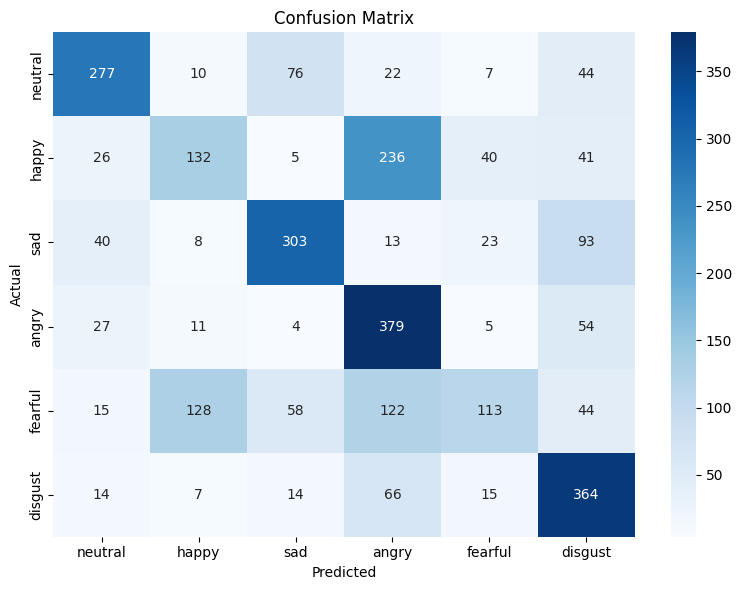

{'auc': 0.8640692234039307, 'top3_acc': 0.9025198221206665, 'acc': 0.5528913736343384, 'acc_per_dataset': {'cremad': 0.5584627964022895, 'radvess': 0.525974025974026, 'savee': 0.4, 'tess': 0.5675}, 'predictions': [3, 0, 4, 1, 3, 1, 3, 1, 5, 3, 1, 3, 3, 3, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 0, 5, 5, 5, 5, 2, 4, 4, 2, 4, 2, 2, 4, 2, 4, 2, 4, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 5, 4, 2, 5, 5, 5, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 3, 3, 3, 3, 3, 5, 3, 5, 3, 0, 5, 5, 3, 5, 5, 5, 4, 5, 5, 5, 1, 4, 5, 5, 4, 1, 5, 1, 4, 3, 3, 4, 1, 3, 4, 3, 3, 1, 1, 3, 1, 4, 1, 3, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 4, 4, 3, 2, 5, 5, 4, 2, 5, 4, 1, 4, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 2, 5, 2, 5, 5, 4, 2, 5, 2, 5, 5, 2, 2, 4, 2, 4, 2, 4, 0, 2, 4, 2, 4, 2, 1, 3, 1, 4, 1, 1, 3, 4, 4, 5, 4, 4, 1, 3, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 5, 4, 5, 2, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 1, 5, 5, 4, 5, 5, 5, 5, 5, 

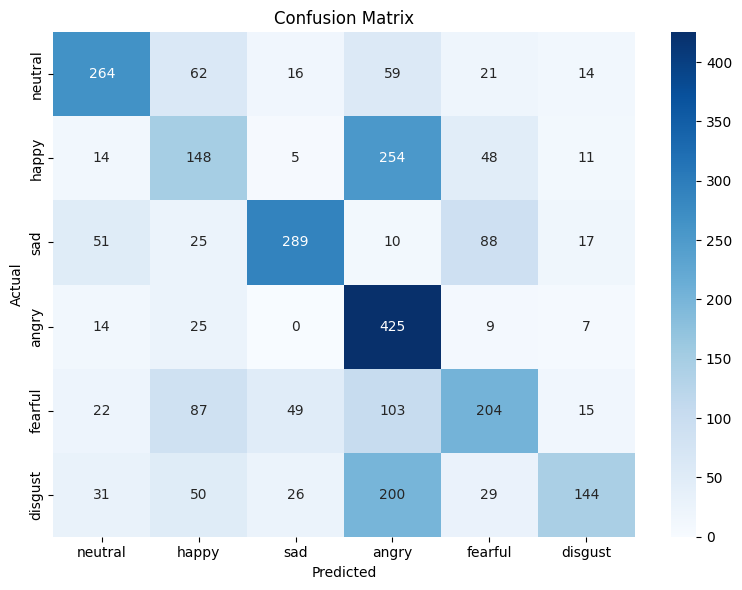

{'auc': 0.8277673721313477, 'top3_acc': 0.8924757838249207, 'acc': 0.5197461247444153, 'acc_per_dataset': {'cremad': 0.5821749795584628, 'radvess': 0.45454545454545453, 'savee': 0.4095238095238095, 'tess': 0.4825}, 'predictions': [3, 1, 4, 3, 0, 1, 3, 1, 3, 3, 3, 3, 1, 3, 2, 5, 5, 5, 2, 0, 5, 1, 5, 1, 2, 0, 5, 3, 2, 4, 2, 4, 1, 1, 4, 2, 2, 1, 4, 4, 0, 4, 3, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 4, 1, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 0, 0, 0, 2, 2, 2, 0, 4, 2, 4, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 4, 3, 3, 3, 3, 4, 4, 4, 5, 1, 4, 1, 3, 3, 3, 1, 4, 4, 5, 1, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 1, 0, 5, 1, 4, 4, 3, 4, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 2, 0, 5, 1, 4, 4, 4, 4, 0, 5, 2, 2, 2, 2, 4, 4, 2, 4, 4, 4, 4, 0, 2, 2, 3, 4, 1, 3, 3, 1, 4, 1, 1, 4, 4, 3, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 5, 5, 2

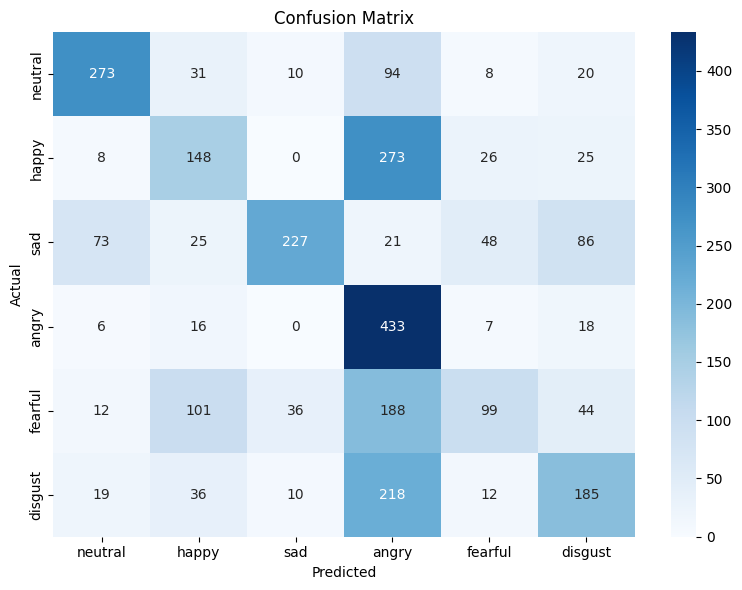

{'auc': 0.7950108647346497, 'top3_acc': 0.8797017931938171, 'acc': 0.48131170868873596, 'acc_per_dataset': {'cremad': 0.5314799672935405, 'radvess': 0.4772727272727273, 'savee': 0.45714285714285713, 'tess': 0.43333333333333335}, 'predictions': [1, 3, 5, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 5, 5, 0, 5, 1, 0, 5, 0, 5, 5, 5, 0, 3, 5, 2, 4, 5, 4, 1, 1, 1, 2, 2, 4, 2, 5, 0, 5, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 5, 5, 2, 5, 1, 4, 2, 1, 5, 5, 5, 5, 5, 4, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 5, 1, 1, 5, 3, 1, 3, 3, 3, 3, 3, 1, 4, 4, 1, 5, 1, 4, 3, 3, 5, 5, 3, 1, 3, 1, 1, 1, 3, 1, 4, 3, 1, 3, 3, 0, 0, 0, 0, 3, 0, 3, 0, 4, 0, 1, 5, 4, 1, 2, 5, 3, 4, 4, 5, 4, 3, 4, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 5, 5, 5, 4, 0, 5, 5, 1, 4, 1, 5, 4, 5, 2, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 5, 4, 4, 3, 3, 1, 1, 3, 1, 4, 1, 4, 4, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 2, 2, 1, 1, 2, 2, 2, 2, 5, 0, 5, 2, 2, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5,

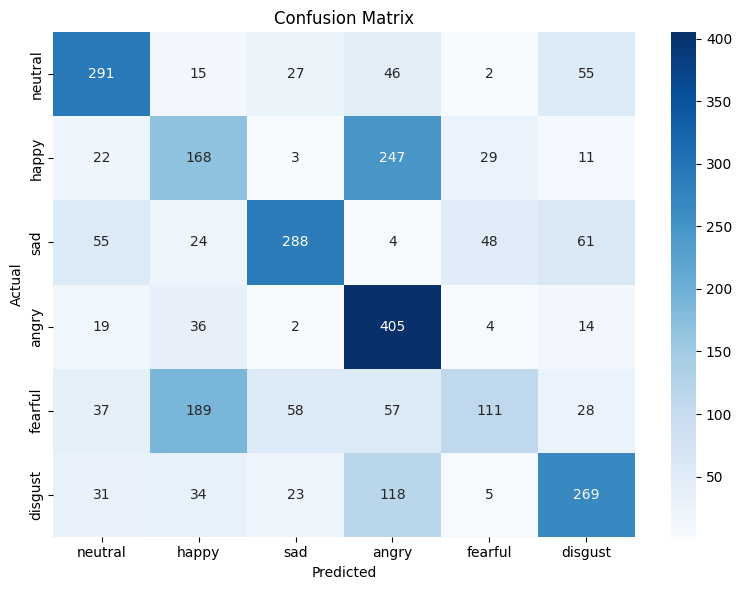

{'auc': 0.8503382802009583, 'top3_acc': 0.9065526127815247, 'acc': 0.5401974320411682, 'acc_per_dataset': {'cremad': 0.5609157808667212, 'radvess': 0.5454545454545454, 'savee': 0.41904761904761906, 'tess': 0.5283333333333333}, 'predictions': [1, 3, 1, 1, 1, 0, 3, 1, 3, 1, 1, 3, 1, 3, 5, 5, 0, 5, 5, 2, 5, 1, 5, 1, 2, 0, 5, 3, 4, 2, 2, 4, 1, 2, 1, 5, 2, 1, 2, 4, 0, 4, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 4, 2, 5, 2, 2, 2, 1, 5, 2, 2, 2, 4, 4, 3, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 3, 3, 5, 3, 1, 3, 5, 3, 1, 5, 3, 1, 5, 1, 1, 1, 1, 4, 1, 3, 1, 4, 1, 4, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 5, 1, 4, 4, 4, 2, 5, 4, 5, 4, 5, 4, 5, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 4, 5, 5, 5, 5, 3, 3, 5, 5, 5, 5, 4, 2, 1, 2, 4, 2, 2, 2, 2, 2, 0, 0, 0, 4, 4, 1, 3, 3, 1, 3, 1, 4, 3, 4, 3, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 5, 2, 2, 2, 2, 5, 2, 4, 2, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3

In [16]:


def run_mel_experiment(seed: int):
    set_seed(seed)

    # Datasets
    train_dataset_mel = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset_mel   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset_mel  = TensorDatasetWithNames(
        X_test_tensor,
        y_test_tensor,
        myDatasets[test_idx]
    )

    # IMPORTANT: seed-controlled shuffling
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader_mel = DataLoader(
        train_dataset_mel,
        batch_size=256,
        shuffle=True,
        generator=g,
        num_workers=4,
        pin_memory=True
    )
    val_loader_mel = DataLoader(
        val_dataset_mel,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader_mel = DataLoader(
        test_dataset_mel,
        batch_size=256,
        shuffle=False
    )

    # Train (re-init model every seed)
    model_mel = MelSpectrogramCNN().to(device)
    model_mel, history_mel = train_model(
        model_mel,
        train_loader_mel,
        val_loader_mel,
        num_epochs=40,
        model_name=f"model_mel_seed{seed}",
        device=device
    )

    # Evaluate
    results_mel = evaluate_model(
        model_mel,
        test_loader_mel,
        f"best_model_mel_seed{seed}.pth",
        device
    )

    print(results_mel)

    return results_mel



seeds = [0, 1, 2, 3, 4]
all_results = []

for s in seeds:
    print(f"\n{'='*20} Seed {s} {'='*20}")
    all_results.append(run_mel_experiment(s))

In [17]:
summary = summarize_with_f1(all_results)
ds_summary = summarize_acc_per_dataset(all_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.8397 ± 0.0288
Macro-F1: 0.5132 ± 0.0240
Acc: 0.5266 ± 0.0279
Top-3: 0.8955 ± 0.0104
cremad: 0.5583 ± 0.0180
radvess: 0.5032 ± 0.0369
savee: 0.4229 ± 0.0219
tess: 0.5093 ± 0.0522



==================== TOPO Seed 0 ====================
Epoch 1/40 - train_loss: 1.7428 - val_loss: 1.7106 - val_auc: 0.6884 - val_top3: 0.6601 - val_acc: 0.3015
✅ Saved best model: 0.3015
Epoch 2/40 - train_loss: 1.6247 - val_loss: 1.6642 - val_auc: 0.7066 - val_top3: 0.6361 - val_acc: 0.2733
Epoch 3/40 - train_loss: 1.5321 - val_loss: 1.5492 - val_auc: 0.7204 - val_top3: 0.7517 - val_acc: 0.3607
✅ Saved best model: 0.3607
Epoch 4/40 - train_loss: 1.4887 - val_loss: 1.5324 - val_auc: 0.7344 - val_top3: 0.7603 - val_acc: 0.3601
Epoch 5/40 - train_loss: 1.4575 - val_loss: 1.5652 - val_auc: 0.7356 - val_top3: 0.7716 - val_acc: 0.3761
✅ Saved best model: 0.3761
Epoch 6/40 - train_loss: 1.4159 - val_loss: 1.6842 - val_auc: 0.7239 - val_top3: 0.7122 - val_acc: 0.3277
Epoch 7/40 - train_loss: 1.4049 - val_loss: 1.5351 - val_auc: 0.7522 - val_top3: 0.7607 - val_acc: 0.3591
Epoch 8/40 - train_loss: 1.3833 - val_loss: 1.4919 - val_auc: 0.7558 - val_top3: 0.8071 - val_acc: 0.3825
✅ Saved best mod

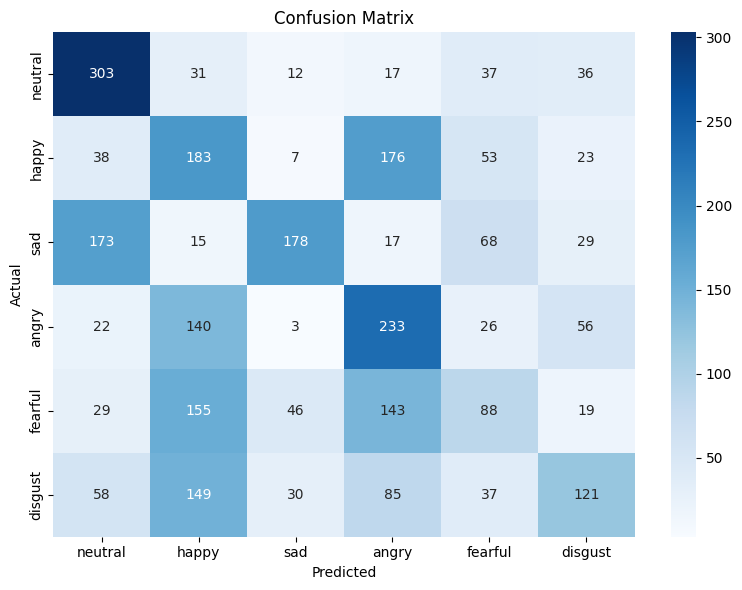


==================== TOPO Seed 1 ====================
Epoch 1/40 - train_loss: 1.7288 - val_loss: 1.7170 - val_auc: 0.6644 - val_top3: 0.5805 - val_acc: 0.2238
✅ Saved best model: 0.2238
Epoch 2/40 - train_loss: 1.6076 - val_loss: 1.5860 - val_auc: 0.7224 - val_top3: 0.7292 - val_acc: 0.3308
✅ Saved best model: 0.3308
Epoch 3/40 - train_loss: 1.5253 - val_loss: 1.5333 - val_auc: 0.7359 - val_top3: 0.7683 - val_acc: 0.3623
✅ Saved best model: 0.3623
Epoch 4/40 - train_loss: 1.4701 - val_loss: 1.5705 - val_auc: 0.7345 - val_top3: 0.7567 - val_acc: 0.3671
✅ Saved best model: 0.3671
Epoch 5/40 - train_loss: 1.4426 - val_loss: 1.5290 - val_auc: 0.7426 - val_top3: 0.7824 - val_acc: 0.3633
Epoch 6/40 - train_loss: 1.3995 - val_loss: 1.4999 - val_auc: 0.7474 - val_top3: 0.7777 - val_acc: 0.3900
✅ Saved best model: 0.3900
Epoch 7/40 - train_loss: 1.3756 - val_loss: 1.4873 - val_auc: 0.7495 - val_top3: 0.7957 - val_acc: 0.3799
Epoch 8/40 - train_loss: 1.3435 - val_loss: 1.5146 - val_auc: 0.7542

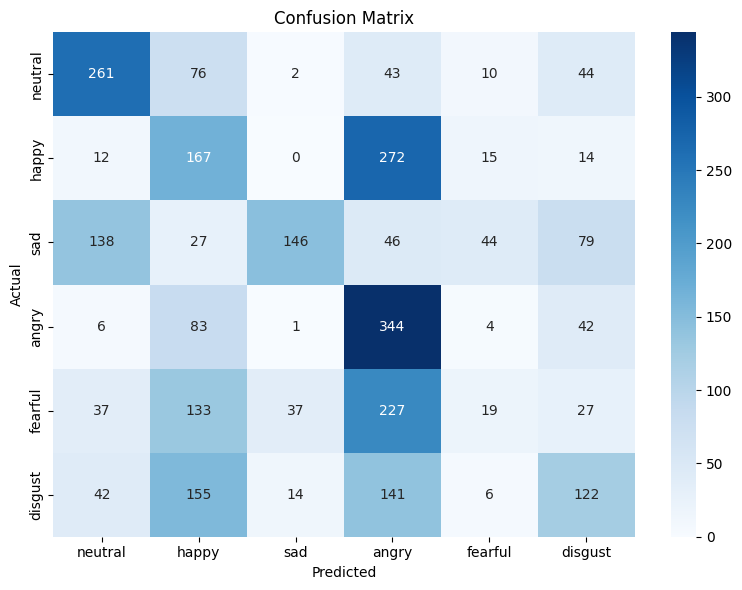


==================== TOPO Seed 2 ====================
Epoch 1/40 - train_loss: 1.7237 - val_loss: 1.7081 - val_auc: 0.6807 - val_top3: 0.5846 - val_acc: 0.2152
✅ Saved best model: 0.2152
Epoch 2/40 - train_loss: 1.6094 - val_loss: 1.5775 - val_auc: 0.7267 - val_top3: 0.7271 - val_acc: 0.3420
✅ Saved best model: 0.3420
Epoch 3/40 - train_loss: 1.5259 - val_loss: 1.5574 - val_auc: 0.7341 - val_top3: 0.7531 - val_acc: 0.3713
✅ Saved best model: 0.3713
Epoch 4/40 - train_loss: 1.4640 - val_loss: 1.5310 - val_auc: 0.7467 - val_top3: 0.7578 - val_acc: 0.3799
✅ Saved best model: 0.3799
Epoch 5/40 - train_loss: 1.4333 - val_loss: 1.5188 - val_auc: 0.7488 - val_top3: 0.7681 - val_acc: 0.3724
Epoch 6/40 - train_loss: 1.3836 - val_loss: 1.5248 - val_auc: 0.7484 - val_top3: 0.7716 - val_acc: 0.3612
Epoch 7/40 - train_loss: 1.3663 - val_loss: 1.5665 - val_auc: 0.7480 - val_top3: 0.7234 - val_acc: 0.3687
Epoch 8/40 - train_loss: 1.3297 - val_loss: 1.6127 - val_auc: 0.7336 - val_top3: 0.7250 - val_a

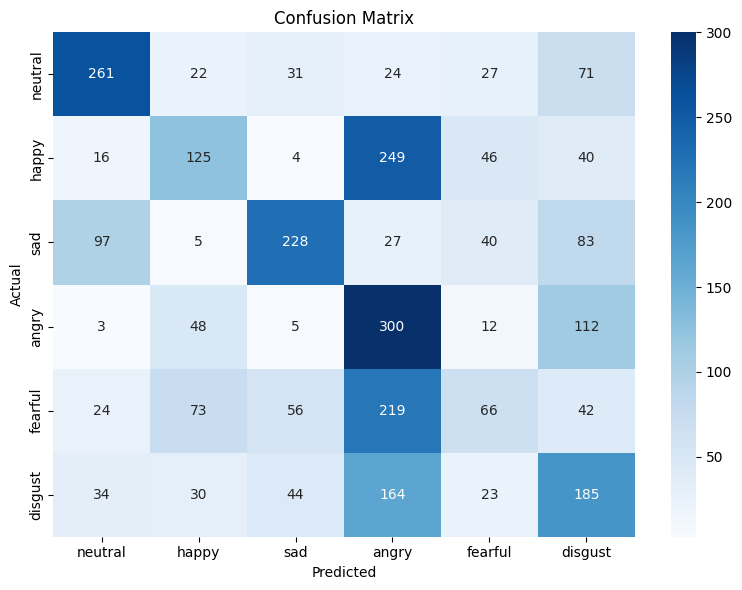


==================== TOPO Seed 3 ====================
Epoch 1/40 - train_loss: 1.7362 - val_loss: 1.7228 - val_auc: 0.6746 - val_top3: 0.5447 - val_acc: 0.1822
✅ Saved best model: 0.1822
Epoch 2/40 - train_loss: 1.6102 - val_loss: 1.6684 - val_auc: 0.7152 - val_top3: 0.6536 - val_acc: 0.2461
✅ Saved best model: 0.2461
Epoch 3/40 - train_loss: 1.5357 - val_loss: 1.5433 - val_auc: 0.7419 - val_top3: 0.7884 - val_acc: 0.3831
✅ Saved best model: 0.3831
Epoch 4/40 - train_loss: 1.4894 - val_loss: 1.5496 - val_auc: 0.7387 - val_top3: 0.7695 - val_acc: 0.3388
Epoch 5/40 - train_loss: 1.4447 - val_loss: 1.5229 - val_auc: 0.7482 - val_top3: 0.7795 - val_acc: 0.3692
Epoch 6/40 - train_loss: 1.4132 - val_loss: 1.4946 - val_auc: 0.7572 - val_top3: 0.7980 - val_acc: 0.3852
✅ Saved best model: 0.3852
Epoch 7/40 - train_loss: 1.3725 - val_loss: 1.5423 - val_auc: 0.7476 - val_top3: 0.7787 - val_acc: 0.3910
✅ Saved best model: 0.3910
Epoch 8/40 - train_loss: 1.3498 - val_loss: 1.5235 - val_auc: 0.7460

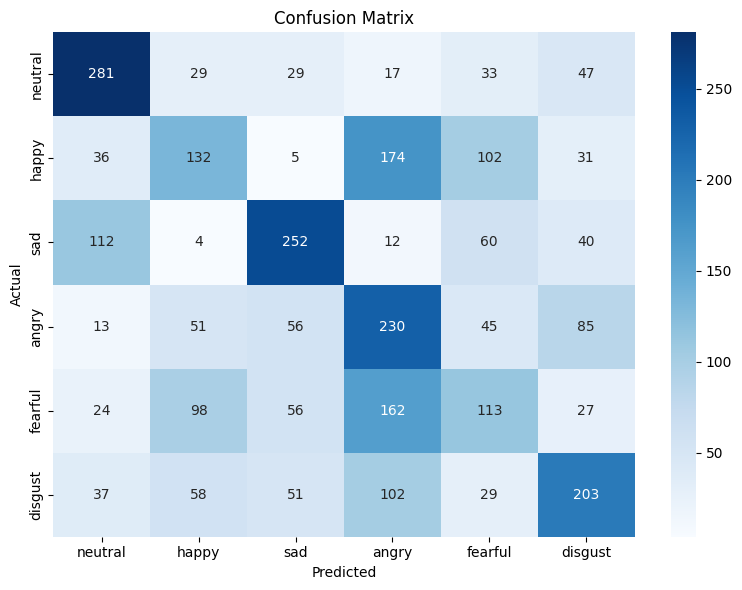


==================== TOPO Seed 4 ====================
Epoch 1/40 - train_loss: 1.7260 - val_loss: 1.7186 - val_auc: 0.6711 - val_top3: 0.5840 - val_acc: 0.2025
✅ Saved best model: 0.2025
Epoch 2/40 - train_loss: 1.6012 - val_loss: 1.5657 - val_auc: 0.7274 - val_top3: 0.7766 - val_acc: 0.3617
✅ Saved best model: 0.3617
Epoch 3/40 - train_loss: 1.5263 - val_loss: 2.0603 - val_auc: 0.6533 - val_top3: 0.5535 - val_acc: 0.1721
Epoch 4/40 - train_loss: 1.4785 - val_loss: 1.5311 - val_auc: 0.7496 - val_top3: 0.7700 - val_acc: 0.3564
Epoch 5/40 - train_loss: 1.4439 - val_loss: 1.5647 - val_auc: 0.7486 - val_top3: 0.7652 - val_acc: 0.3809
✅ Saved best model: 0.3809
Epoch 6/40 - train_loss: 1.4089 - val_loss: 1.5131 - val_auc: 0.7536 - val_top3: 0.7957 - val_acc: 0.3921
✅ Saved best model: 0.3921
Epoch 7/40 - train_loss: 1.3863 - val_loss: 1.5496 - val_auc: 0.7435 - val_top3: 0.7535 - val_acc: 0.3490
Epoch 8/40 - train_loss: 1.3583 - val_loss: 1.5669 - val_auc: 0.7525 - val_top3: 0.7571 - val_a

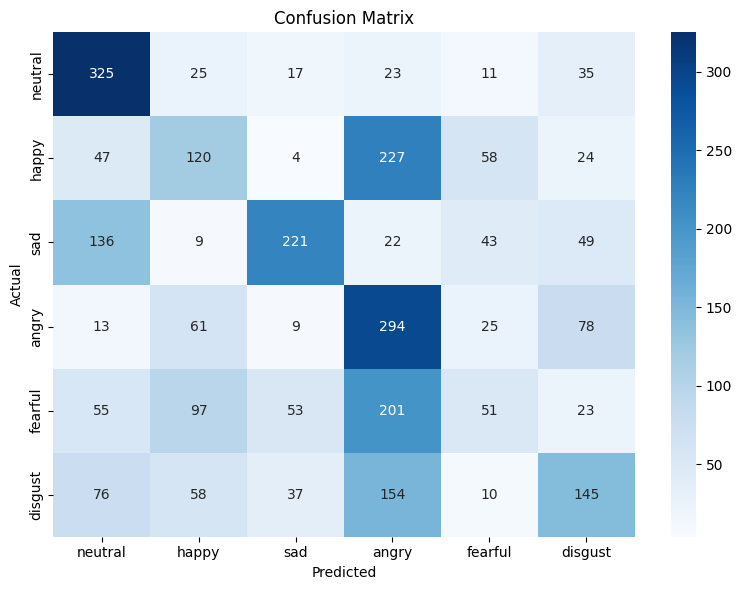

Macro-F1: 0.3903 ± 0.0276
cremad: 0.4352 ± 0.0152
radvess: 0.2442 ± 0.0363
savee: 0.2743 ± 0.0671
tess: 0.4193 ± 0.0319


In [ ]:
def run_topo_experiment(seed: int):
    set_seed(seed)

    train_dataset_topo = TensorDataset(X_train2_tensor, y_train_tensor)
    val_dataset_topo   = TensorDataset(X_val2_tensor, y_val_tensor)
    test_dataset_topo  = TensorDatasetWithNames(
        X_test2_tensor,
        y_test_tensor,
        myDatasets[test_idx]
    )

    g = torch.Generator()
    g.manual_seed(seed)

    train_loader_topo = DataLoader(
        train_dataset_topo,
        batch_size=256,
        shuffle=True,
        generator=g,
        num_workers=4,
        pin_memory=True
    )
    val_loader_topo = DataLoader(
        val_dataset_topo,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader_topo = DataLoader(
        test_dataset_topo,
        batch_size=256,
        shuffle=False
    )

    # Train (re-init every seed)
    model_topo = TopologicalCNN().to(device)
    model_topo, history_topo = train_model(
        model_topo,
        train_loader_topo,
        val_loader_topo,
        num_epochs=40,
        model_name=f"model_topo_seed{seed}",
        device=device
    )

    results_topo = evaluate_model(
        model_topo,
        test_loader_topo,
        f"best_model_topo_seed{seed}.pth",
        device
    )

    return results_topo



seeds = [0, 1, 2, 3, 4]
all_results_topo = []

for s in seeds:
    print(f"\n{'='*20} TOPO Seed {s} {'='*20}")
    all_results_topo.append(run_topo_experiment(s))

In [15]:
summary = summarize_with_f1(all_results_topo)
ds_summary = summarize_acc_per_dataset(all_results_topo)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.7615 ± 0.0131
Macro-F1: 0.3903 ± 0.0276
Acc: 0.4018 ± 0.0206
Top-3: 0.8387 ± 0.0134
cremad: 0.4352 ± 0.0152
radvess: 0.2442 ± 0.0363
savee: 0.2743 ± 0.0671
tess: 0.4193 ± 0.0319



==================== FUSION Seed 0 ====================
Epoch 1/40 - train_loss: 1.7481 - val_loss: 1.8026 - val_auc: 0.6362 - val_top3: 0.5178 - val_acc: 0.2158
✅ Saved best model: 0.2158
Epoch 2/40 - train_loss: 1.5321 - val_loss: 2.1692 - val_auc: 0.6571 - val_top3: 0.5536 - val_acc: 0.2142
Epoch 3/40 - train_loss: 1.3729 - val_loss: 2.0869 - val_auc: 0.7240 - val_top3: 0.6857 - val_acc: 0.3053
✅ Saved best model: 0.3053
Epoch 4/40 - train_loss: 1.2596 - val_loss: 7.3616 - val_auc: 0.6139 - val_top3: 0.5637 - val_acc: 0.1705
Epoch 5/40 - train_loss: 1.1724 - val_loss: 1.4841 - val_auc: 0.7897 - val_top3: 0.7752 - val_acc: 0.3863
✅ Saved best model: 0.3863
Epoch 6/40 - train_loss: 1.0919 - val_loss: 1.4721 - val_auc: 0.7892 - val_top3: 0.8098 - val_acc: 0.4129
✅ Saved best model: 0.4129
Epoch 7/40 - train_loss: 1.0513 - val_loss: 1.6171 - val_auc: 0.7829 - val_top3: 0.7448 - val_acc: 0.3708
Epoch 8/40 - train_loss: 1.0190 - val_loss: 1.7398 - val_auc: 0.8004 - val_top3: 0.8022 - val

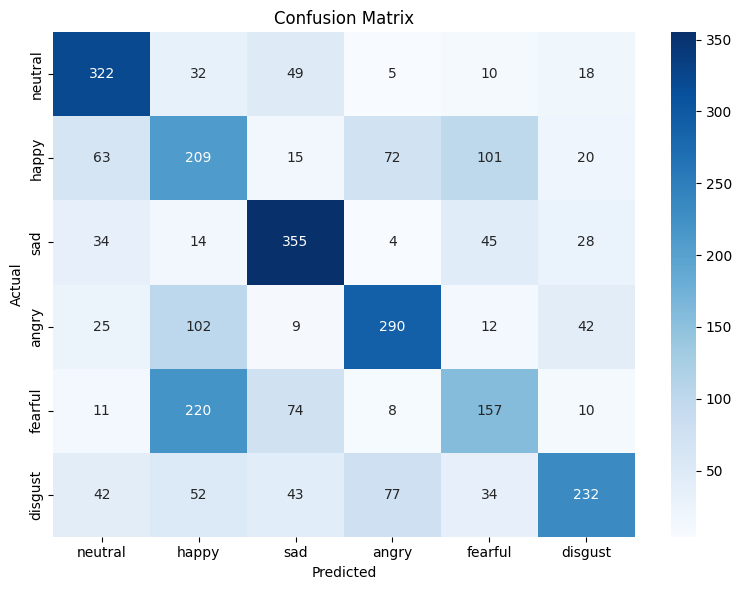


==================== FUSION Seed 1 ====================
Epoch 1/40 - train_loss: 1.7182 - val_loss: 1.6625 - val_auc: 0.7164 - val_top3: 0.7655 - val_acc: 0.3074
✅ Saved best model: 0.3074
Epoch 2/40 - train_loss: 1.4821 - val_loss: 1.4703 - val_auc: 0.7440 - val_top3: 0.7852 - val_acc: 0.3612
✅ Saved best model: 0.3612
Epoch 3/40 - train_loss: 1.3450 - val_loss: 1.7571 - val_auc: 0.7349 - val_top3: 0.7073 - val_acc: 0.3090
Epoch 4/40 - train_loss: 1.2684 - val_loss: 2.7604 - val_auc: 0.7159 - val_top3: 0.5959 - val_acc: 0.2435
Epoch 5/40 - train_loss: 1.2171 - val_loss: 1.4521 - val_auc: 0.7812 - val_top3: 0.8231 - val_acc: 0.4374
✅ Saved best model: 0.4374
Epoch 6/40 - train_loss: 1.1552 - val_loss: 1.8269 - val_auc: 0.7495 - val_top3: 0.7368 - val_acc: 0.3388
Epoch 7/40 - train_loss: 1.1289 - val_loss: 1.4512 - val_auc: 0.8067 - val_top3: 0.8435 - val_acc: 0.4976
✅ Saved best model: 0.4976
Epoch 8/40 - train_loss: 1.0453 - val_loss: 1.3787 - val_auc: 0.8181 - val_top3: 0.8254 - val

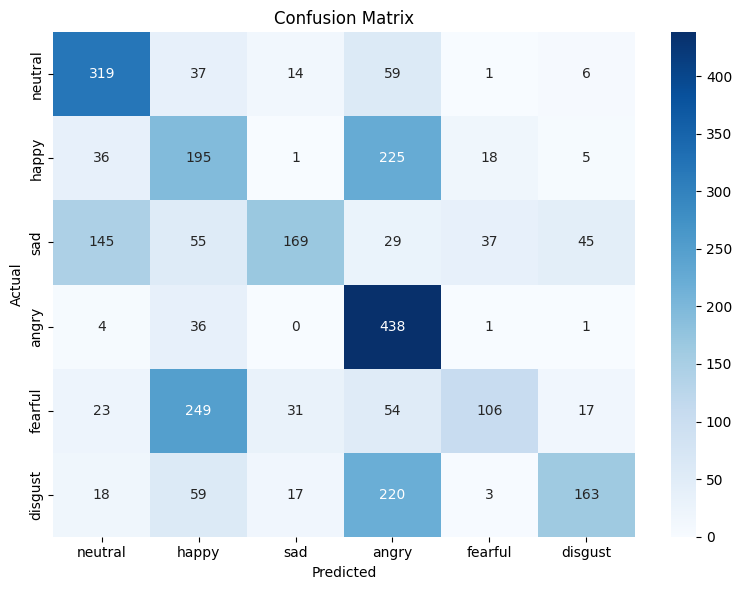


==================== FUSION Seed 2 ====================
Epoch 1/40 - train_loss: 1.7631 - val_loss: 1.7285 - val_auc: 0.7217 - val_top3: 0.6447 - val_acc: 0.2744
✅ Saved best model: 0.2744
Epoch 2/40 - train_loss: 1.4866 - val_loss: 1.6738 - val_auc: 0.7348 - val_top3: 0.6714 - val_acc: 0.2568
Epoch 3/40 - train_loss: 1.3371 - val_loss: 2.4054 - val_auc: 0.6816 - val_top3: 0.6588 - val_acc: 0.2866
✅ Saved best model: 0.2866
Epoch 4/40 - train_loss: 1.2403 - val_loss: 1.3944 - val_auc: 0.7887 - val_top3: 0.8191 - val_acc: 0.4278
✅ Saved best model: 0.4278
Epoch 5/40 - train_loss: 1.1391 - val_loss: 2.9581 - val_auc: 0.6564 - val_top3: 0.5468 - val_acc: 0.2056
Epoch 6/40 - train_loss: 1.0922 - val_loss: 1.8854 - val_auc: 0.7836 - val_top3: 0.6966 - val_acc: 0.3324
Epoch 7/40 - train_loss: 1.0278 - val_loss: 3.2708 - val_auc: 0.7297 - val_top3: 0.6851 - val_acc: 0.2893
Epoch 8/40 - train_loss: 0.9669 - val_loss: 2.7753 - val_auc: 0.7499 - val_top3: 0.5703 - val_acc: 0.2701
Epoch 9/40 - t

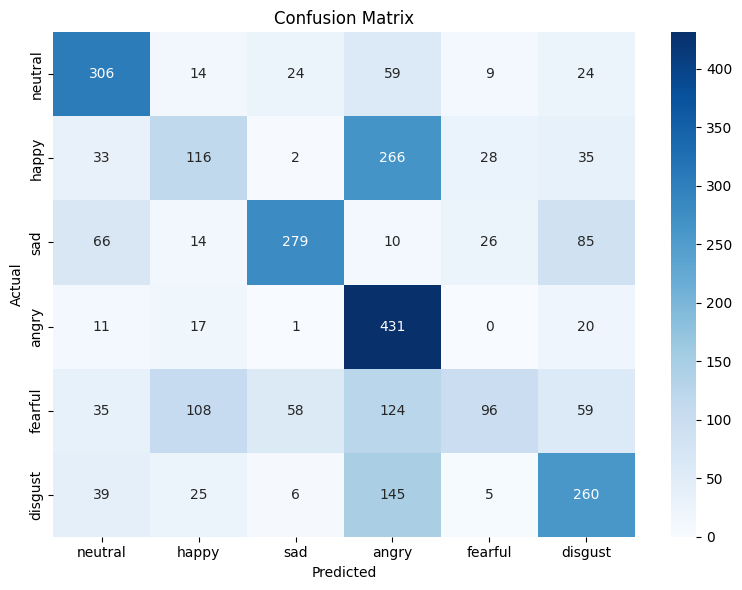


==================== FUSION Seed 3 ====================
Epoch 1/40 - train_loss: 1.7314 - val_loss: 1.7126 - val_auc: 0.7116 - val_top3: 0.7193 - val_acc: 0.2717
✅ Saved best model: 0.2717
Epoch 2/40 - train_loss: 1.5304 - val_loss: 1.5631 - val_auc: 0.7283 - val_top3: 0.7273 - val_acc: 0.3394
✅ Saved best model: 0.3394
Epoch 3/40 - train_loss: 1.3740 - val_loss: 1.7178 - val_auc: 0.7284 - val_top3: 0.6851 - val_acc: 0.2904
Epoch 4/40 - train_loss: 1.2436 - val_loss: 1.3992 - val_auc: 0.7848 - val_top3: 0.8224 - val_acc: 0.4273
✅ Saved best model: 0.4273
Epoch 5/40 - train_loss: 1.1442 - val_loss: 1.4999 - val_auc: 0.7931 - val_top3: 0.7525 - val_acc: 0.3692
Epoch 6/40 - train_loss: 1.0873 - val_loss: 1.6582 - val_auc: 0.7680 - val_top3: 0.7861 - val_acc: 0.3985
Epoch 7/40 - train_loss: 1.0267 - val_loss: 2.0830 - val_auc: 0.7429 - val_top3: 0.7159 - val_acc: 0.3500
Epoch 8/40 - train_loss: 0.9906 - val_loss: 1.4017 - val_auc: 0.8052 - val_top3: 0.8101 - val_acc: 0.4513
✅ Saved best m

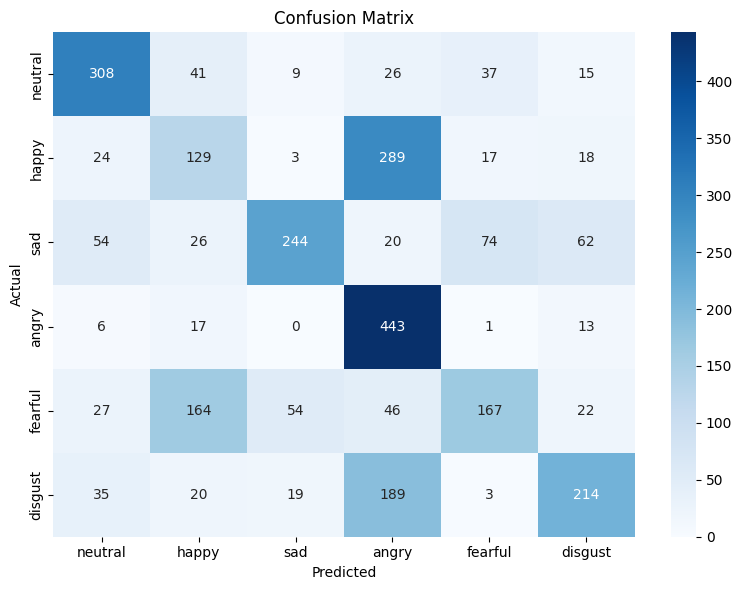


==================== FUSION Seed 4 ====================
Epoch 1/40 - train_loss: 1.7447 - val_loss: 1.7581 - val_auc: 0.6515 - val_top3: 0.5534 - val_acc: 0.2163
✅ Saved best model: 0.2163
Epoch 2/40 - train_loss: 1.5408 - val_loss: 1.6984 - val_auc: 0.6956 - val_top3: 0.6865 - val_acc: 0.2952
✅ Saved best model: 0.2952
Epoch 3/40 - train_loss: 1.4299 - val_loss: 1.5445 - val_auc: 0.7333 - val_top3: 0.7559 - val_acc: 0.3372
✅ Saved best model: 0.3372
Epoch 4/40 - train_loss: 1.3323 - val_loss: 1.5354 - val_auc: 0.7519 - val_top3: 0.7914 - val_acc: 0.3729
✅ Saved best model: 0.3729
Epoch 5/40 - train_loss: 1.2150 - val_loss: 1.6676 - val_auc: 0.7269 - val_top3: 0.6513 - val_acc: 0.3063
Epoch 6/40 - train_loss: 1.1456 - val_loss: 1.8389 - val_auc: 0.7506 - val_top3: 0.7016 - val_acc: 0.2706
Epoch 7/40 - train_loss: 1.0976 - val_loss: 1.9058 - val_auc: 0.7617 - val_top3: 0.6808 - val_acc: 0.2541
Epoch 8/40 - train_loss: 1.0169 - val_loss: 1.7839 - val_auc: 0.7617 - val_top3: 0.7689 - val

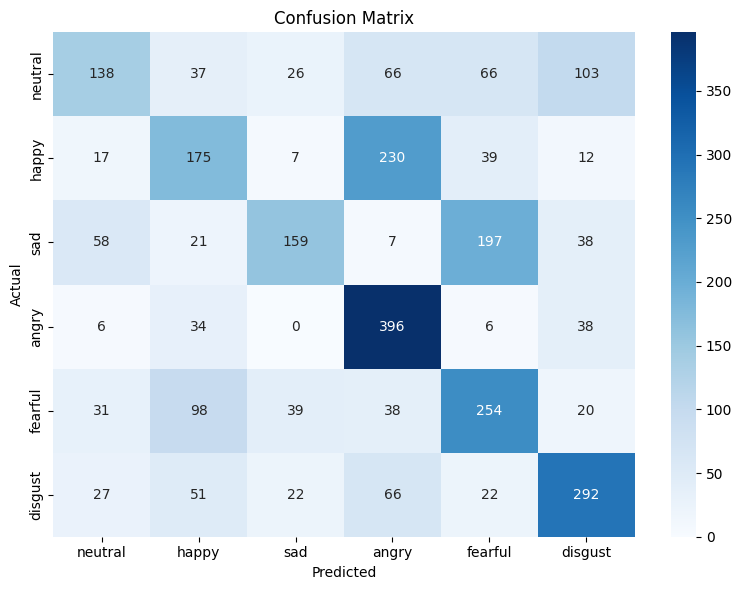

In [18]:
def run_fusion_experiment(seed: int):
    set_seed(seed)

    # Datasets
    train_dataset_comb = TensorDataset(X_train_tensor, X_train2_tensor, y_train_tensor)
    val_dataset_comb   = TensorDataset(X_val_tensor, X_val2_tensor, y_val_tensor)
    test_dataset_comb  = TensorDatasetWithNamesComb(
        X_test_tensor,
        X_test2_tensor,
        y_test_tensor,
        myDatasets[test_idx]
    )

    # Seed-controlled shuffling
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader_comb = DataLoader(
        train_dataset_comb,
        batch_size=256,
        shuffle=True,
        generator=g,
        num_workers=4,
        pin_memory=True
    )
    val_loader_comb = DataLoader(
        val_dataset_comb,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader_comb = DataLoader(
        test_dataset_comb,
        batch_size=256,
        shuffle=False
    )

    # Train (re-init every seed)
    model_comb = CombinedFusionModel().to(device)
    model_comb, history_comb = train_model(
        model_comb,
        train_loader_comb,
        val_loader_comb,
        num_epochs=40,
        model_name=f"model_combined_seed{seed}",   # avoid overwrite
        device=device
    )

    # Evaluate (seed-specific checkpoint)
    results_comb = evaluate_model(
        model_comb,
        test_loader_comb,
        f"best_model_combined_seed{seed}.pth",     # ensure train_model saves this
        device
    )

    return results_comb


# ---- Run multiple seeds and summarize ----
seeds = [0, 1, 2, 3, 4]   # N=5
all_results_comb = []

for s in seeds:
    print(f"\n{'='*20} FUSION Seed {s} {'='*20}")
    all_results_comb.append(run_fusion_experiment(s))

In [19]:
summary = summarize_with_f1(all_results_comb)
ds_summary = summarize_acc_per_dataset(all_results_comb)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.8318 ± 0.0202
Macro-F1: 0.5070 ± 0.0314
Acc: 0.5192 ± 0.0250
Top-3: 0.8770 ± 0.0261
cremad: 0.5380 ± 0.0236
radvess: 0.4506 ± 0.0346
savee: 0.4190 ± 0.0997
tess: 0.5263 ± 0.0618



Interpretability Analysis: Integrated Gradients

Per-Channel Importance (Integrated Gradients):
Channel 0 (Euclidean (H0)): 0.000267
Channel 1 (Euclidean (H1)): 0.000087
Channel 2 (Temporal (H0)): 0.011266
Channel 3 (Temporal (H1)): 0.005305
Channel 4 (Wasserstein (H0)): 0.007490
Channel 5 (Wasserstein (H1)): 0.002957


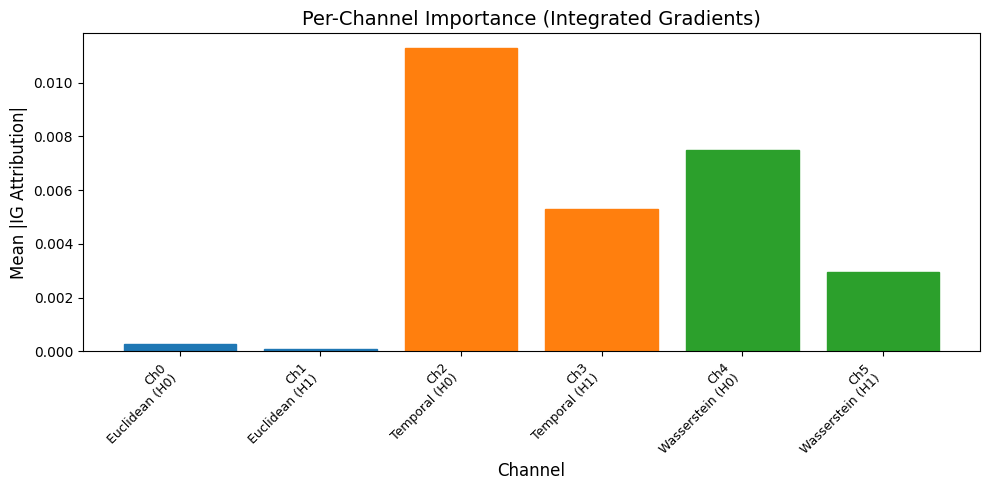

In [29]:
# Interpretability: Integrated Gradients per Channel
from pathlib import Path

def compute_channel_importance_ig(model, test_loader, device, save_dir="attr_summary"):
    """
    Compute per-channel attribution using Integrated Gradients.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    ig = IntegratedGradients(model)
    model.eval()

    acc_global = None
    count_global = 0

    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        baseline = torch.zeros_like(X_batch)

        # Compute IG
        attr = ig.attribute(X_batch, baselines=baseline, target=y_batch)
        batch_attr = attr.abs().sum(dim=0).detach().cpu()  # (C, H, W)

        acc_global = batch_attr if acc_global is None else acc_global + batch_attr
        count_global += X_batch.size(0)

    mean_attr_global = acc_global / max(count_global, 1)
    C, H, W = mean_attr_global.shape

    # Per-channel importance scores
    per_channel_scores = mean_attr_global.view(C, -1).mean(dim=1).numpy()

    print("\nPer-Channel Importance (Integrated Gradients):")
    channel_names = [
        'Euclidean (H0)',
        'Euclidean (H1)',
        'Temporal (H0)',
        'Temporal (H1)',
        'Wasserstein (H0)',
        'Wasserstein (H1)'
    ]
    for c, (name, score) in enumerate(zip(channel_names, per_channel_scores)):
        print(f"Channel {c} ({name}): {score:.6f}")

    # Save heatmaps
    def save_heat(heat2d, title, path):
        h = (heat2d - heat2d.min()) / (heat2d.max() - heat2d.min() + 1e-8)
        plt.figure(figsize=(4.5, 4))
        plt.imshow(h, cmap="jet")
        plt.title(title)
        plt.axis("off")
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(path, dpi=300, bbox_inches='tight')
        plt.close()

    for c in range(C):
        heat = mean_attr_global[c].numpy()
        save_heat(heat, f"IG Attribution — {channel_names[c]}",
                  save_dir / f"ig_channel_{c}.png")

    # Bar chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(C), per_channel_scores)
    plt.xlabel("Channel", fontsize=12)
    plt.ylabel("Mean |IG Attribution|", fontsize=12)
    plt.title("Per-Channel Importance (Integrated Gradients)", fontsize=14)
    plt.xticks(range(C), [f"Ch{c}\n{name}" for c, name in enumerate(channel_names)],
               rotation=45, ha='right', fontsize=9)

    # Color bars by metric type
    colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c']
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.tight_layout()
    plt.savefig(save_dir / "channel_importance_ig.png", dpi=300, bbox_inches='tight')
    plt.show()

    np.save(save_dir / "per_channel_scores_ig.npy", per_channel_scores)
    return per_channel_scores

test_dataset_topo  = TensorDataset(
    X_test2_tensor,
    y_test_tensor
)

test_loader_topo = DataLoader(
    test_dataset_topo,
    batch_size=256,
    shuffle=False
)

model_topo = TopologicalCNN().to(device)
# Run IG analysis on topological
print("\n" + "="*60)
print("Interpretability Analysis: Integrated Gradients")
print("="*60)
model_topo.load_state_dict(torch.load("best_model_topo_seed0.pth"))
channel_scores_ig = compute_channel_importance_ig(model_topo, test_loader_topo, device)

In [30]:
# Occlusion analysis per channel
def compute_channel_importance_occlusion(model, test_loader, device,
                                         patch_size=8, stride=4,
                                         save_dir="attr_summary"):
    """
    Compute per-channel importance using Occlusion method.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    occ = Occlusion(model)
    model.eval()

    # Sample a few examples for visualization
    X_sample, y_sample = next(iter(test_loader))
    X_sample = X_sample[:5].to(device)  # First 5 samples
    y_sample = y_sample[:5].to(device)

    channel_names = [
        'Euclidean (clean)',
        'Euclidean (noise)',
        'Temporal (clean)',
        'Temporal (noise)',
        'Wasserstein (clean)',
        'Wasserstein (noise)'
    ]

    C = X_sample.shape[1]
    attr_per_channel = []

    for sample_idx in range(len(X_sample)):
        x = X_sample[sample_idx:sample_idx+1]
        target = int(y_sample[sample_idx])

        for c in range(C):
            attr = occ.attribute(
                x,
                target=target,
                sliding_window_shapes=(1, patch_size, patch_size),
                strides=(1, stride, stride),
                baselines=0
            )
            # Extract channel c attribution
            heat = attr[:, c:c+1, :, :].abs().mean(dim=1)[0].detach().cpu().numpy()
            attr_per_channel.append(heat)

            # Save individual sample heatmap
            plt.figure(figsize=(5, 4))
            plt.imshow(heat, cmap='jet')
            plt.title(f"Sample {sample_idx} - {channel_names[c]}")
            plt.colorbar()
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(save_dir / f"occ_sample{sample_idx}_ch{c}.png", dpi=150)
            plt.close()

    print("\n✅ Occlusion analysis complete. Heatmaps saved to", save_dir)
    return attr_per_channel


# Run Occlusion analysis
if 'model_topo' in locals() and 'test_loader_topo' in locals():
    print("\n" + "="*60)
    print("Interpretability Analysis: Occlusion")
    print("="*60)
    model_topo.load_state_dict(torch.load("best_model_topo_seed0.pth"))
    occlusion_attrs = compute_channel_importance_occlusion(
        model_topo, test_loader_topo, device, patch_size=8, stride=4
    )


Interpretability Analysis: Occlusion

✅ Occlusion analysis complete. Heatmaps saved to attr_summary



Embedding Visualization
Computing UMAP projection...


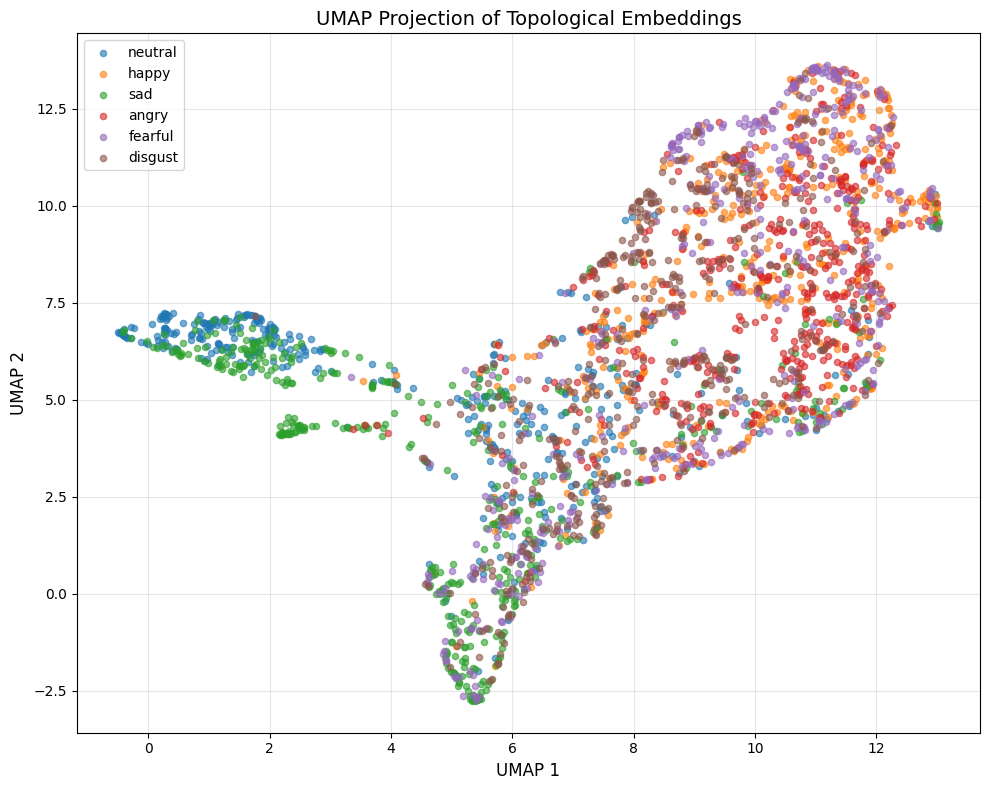


✅ Embedding visualization saved: embedding_umap.png


In [28]:
# Extract and visualize embeddings
def visualize_embeddings(model, test_loader, device):
    """
    Extract 64-dim embeddings and project to 2D using UMAP.
    """
    import umap.umap_ as umap

    model.eval()
    embs, labs = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            z = model(X_batch, return_embedding=True)  # (B, 64)
            embs.append(z.cpu().numpy())
            labs.append(y_batch.numpy())

    X_emb = np.concatenate(embs, axis=0)
    y_emb = np.concatenate(labs, axis=0)

    # UMAP projection
    print("Computing UMAP projection...")
    X_2d = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X_emb)

    # Plot
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    plt.figure(figsize=(10, 8))
    for c, (name, color) in enumerate(zip(emotions, colors)):
        mask = (y_emb == c)
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=20, alpha=0.6,
                    label=name, color=color)

    plt.title("UMAP Projection of Topological Embeddings", fontsize=14)
    plt.xlabel("UMAP 1", fontsize=12)
    plt.ylabel("UMAP 2", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('embedding_umap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Embedding visualization saved: embedding_umap.png")
    return X_2d, y_emb


# Visualize topological embeddings
if 'model_topo' in locals() and 'test_loader_topo' in locals():
    print("\n" + "="*60)
    print("Embedding Visualization")
    print("="*60)
    model_topo.load_state_dict(torch.load("best_model_topo_seed0.pth"))
    X_2d, y_2d = visualize_embeddings(model_topo, test_loader_topo, device)

In [26]:
# Flexible Topological CNN for ablation studies
class FlexibleTopologicalCNN(nn.Module):
    """CNN that accepts variable number of topological channels."""
    def __init__(self, num_channels=6, num_classes=6):
        super(FlexibleTopologicalCNN, self).__init__()
        self.num_channels = num_channels
        self.features = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def train_ablation_model(X_train, X_val, X_test, y_train, y_val, y_test,
                         channel_indices, model_name, device,
                         num_epochs=30, lr=1e-3, verbose=False):
    """
    Train a model with specific channel subset.

    Args:
        X_train, X_val, X_test: Full topological feature tensors (B, 6, H, W)
        y_train, y_val, y_test: Label tensors
        channel_indices: List of channel indices to use
        model_name: Name for saving the model
        device: Training device
        num_epochs: Number of training epochs
        lr: Learning rate
        verbose: Print training progress

    Returns:
        Dict with test metrics
    """
    # Select specified channels
    X_train_sub = X_train[:, channel_indices, :, :]
    X_val_sub = X_val[:, channel_indices, :, :]
    X_test_sub = X_test[:, channel_indices, :, :]

    # Create data loaders
    train_dataset = TensorDataset(X_train_sub, y_train)
    val_dataset = TensorDataset(X_val_sub, y_val)
    test_dataset = TensorDataset(X_test_sub, y_test)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256)
    test_loader = DataLoader(test_dataset, batch_size=256)

    # Initialize model
    model = FlexibleTopologicalCNN(num_channels=len(channel_indices)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)

    best_val_acc = 0.0
    best_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.softmax(outputs, dim=1)
                val_preds.append(preds)
                val_labels.append(y_batch)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_auc = auroc(val_preds, val_labels).item()
        y_pred = torch.argmax(val_preds, dim=1)
        accuracy = (y_pred == val_labels).float().mean().item()


        if accuracy > best_val_acc:
            best_val_acc = accuracy
            best_state = model.state_dict().copy()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f}")

    # Test with best model
    model.load_state_dict(best_state)
    model.eval()

    test_preds, test_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.softmax(outputs, dim=1)
            test_preds.append(preds)
            test_labels.append(y_batch)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_auc = auroc(test_preds, test_labels).item()
    test_acc = (torch.argmax(test_preds, dim=1) == test_labels).float().mean().item()

    return {
        'auc': test_auc,
        'acc': test_acc,
        'val_acc': best_val_acc
    }


print("✅ Ablation training functions defined")

✅ Ablation training functions defined


In [27]:
# Run ablation experiments
if 'X_train2_tensor' in locals():
    print("="*60)
    print("Running Ablation Study")
    print("="*60)
    SEEDS = [0, 1, 2, 3, 4]

    # Define ablation configurations
    ablation_configs = {
        # Baseline
        'All 6 channels': [0, 1, 2, 3, 4, 5],

        # Individual channels
        'Euclidean H0': [0],
        'Euclidean H1': [1],
        'Temporal H0': [2],
        'Temporal H1': [3],
        'Wasserstein H0': [4],
        'Wasserstein H1': [5],

        # Metric groups
        'Euclidean only': [0, 1],
        'Temporal only': [2, 3],
        'Wasserstein only': [4, 5],

        # Leave-one-out (remove metric groups)
        'Without Euclidean': [2, 3, 4, 5],
        'Without Temporal': [0, 1, 4, 5],
        'Without Wasserstein': [0, 1, 2, 3],
    }

    ablation_results = {}

    ablation_results = {}

for config_name, channels in ablation_configs.items():
    print(f"\n{config_name} (channels {channels})...")

    seed_results = []

    for seed in SEEDS:
            # Set seeds
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            results = train_ablation_model(
                X_train2_tensor, X_val2_tensor, X_test2_tensor,
                y_train_tensor, y_val_tensor, y_test_tensor,
                channel_indices=channels,
                model_name=f"ablation_{config_name.replace(' ', '_')}_seed{seed}",
                device=device,
                num_epochs=40,
                lr=1e-3,
                verbose=False
            )

            seed_results.append(results)

    # Aggregate metrics
    aucs = np.array([r['auc'] for r in seed_results], dtype=float)
    accs = np.array([r['acc'] for r in seed_results], dtype=float)

    ablation_results[config_name] = {
        'auc_mean': aucs.mean(),
        'auc_std': aucs.std(ddof=1),
        'acc_mean': accs.mean(),
        'acc_std': accs.std(ddof=1),
        'num_seeds': len(SEEDS)
    }

    print(
        f"  ✅ Test AUC: {aucs.mean():.4f} ± {aucs.std(ddof=1):.4f} | "
        f"Test Acc: {accs.mean():.4f} ± {accs.std(ddof=1):.4f}"
    )

    print("\n" + "="*60)
    print("Ablation Study Complete (all configs, multi-seed)!")
    print("="*60)

else:
    print("⚠️ Training data not available. Please run previous cells first.")

Running Ablation Study

All 6 channels (channels [0, 1, 2, 3, 4, 5])...
  ✅ Test AUC: 0.7596 ± 0.0107 | Test Acc: 0.4048 ± 0.0140

Ablation Study Complete (all configs, multi-seed)!

Euclidean H0 (channels [0])...
  ✅ Test AUC: 0.7306 ± 0.0191 | Test Acc: 0.3255 ± 0.0246

Ablation Study Complete (all configs, multi-seed)!

Euclidean H1 (channels [1])...
  ✅ Test AUC: 0.5753 ± 0.0418 | Test Acc: 0.2271 ± 0.0354

Ablation Study Complete (all configs, multi-seed)!

Temporal H0 (channels [2])...
  ✅ Test AUC: 0.7470 ± 0.0122 | Test Acc: 0.3548 ± 0.0138

Ablation Study Complete (all configs, multi-seed)!

Temporal H1 (channels [3])...
  ✅ Test AUC: 0.6277 ± 0.0106 | Test Acc: 0.2774 ± 0.0121

Ablation Study Complete (all configs, multi-seed)!

Wasserstein H0 (channels [4])...
  ✅ Test AUC: 0.6959 ± 0.0208 | Test Acc: 0.2944 ± 0.0196

Ablation Study Complete (all configs, multi-seed)!

Wasserstein H1 (channels [5])...
  ✅ Test AUC: 0.6336 ± 0.0041 | Test Acc: 0.2625 ± 0.0083

Ablation Study 